In [25]:
import os
os.chdir("..")  # Ajusta según tu estructura


# Generate_folders_ImageDataProject.py

In [1]:
import os

def create_project_structure():
    """
    Create a folder structure for an image data project.

    The base path is automatically set to the current working directory.
    """
    # Set the base directory to the current working directory
    base_path = os.getcwd()

    # Define the folder structure
    structure = {
        "data": [
            "raw",
            "processed",
            "annotations"
        ],
        "src": [
            "data_preprocessing",
            "models",
            "visualization"
        ],
        "models": [
            "checkpoints",
            "final"
        ],
        "results": [
            "predictions",
            "logs"
        ],
        "docs": [],
        "notebooks": [],
        "tests": [],
        "presentation": []
    }

    # Function to create folders recursively
    def create_folders(base, folders):
        for folder, subfolders in folders.items():
            folder_path = os.path.join(base, folder)
            os.makedirs(folder_path, exist_ok=True)
            for subfolder in subfolders:
                os.makedirs(os.path.join(folder_path, subfolder), exist_ok=True)

    # Create the structure
    create_folders(base_path, structure)

    print(f"Project structure created successfully at: {base_path}")

# Example usage
if __name__ == "__main__":
    create_project_structure()


Project structure created successfully at: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision


# Exportar Refurbished PDF

In [4]:
!jupyter nbconvert --to pdf LEGO_Bricks_Identification_Project_Overview.ipynb
# !jupyter nbconvert --to pdf LEGO_Bricks_Identification_Project_Technical_Report.ipynb

[NbConvertApp] Converting notebook LEGO_Bricks_Identification_Project_Overview.ipynb to pdf
[NbConvertApp] Writing 34205 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 42940 bytes to LEGO_Bricks_Identification_Project_Overview.pdf


# Refurbishing Pipeline

(chatGPT is having bugs remembering converstions)

# "

¡Perfecto! Vamos a estructurar esta entrevista para guiarte a reflexionar sobre cada etapa del proyecto y asegurarnos de que tu storytelling esté alineado con las mejores prácticas. Este enfoque también nos permitirá planear cómo documentar, reproducir y organizar el proyecto de manera profesional.

Entrevista Inicial
Te haré preguntas relevantes por etapas del proyecto. Responde según tu experiencia, y construiré secciones del documento con base en tus respuestas. También sugeriré scripts o ajustes según lo que compartas.

1. Origen del Proyecto
¿Qué te motivó a iniciar este proyecto? ¿Fue un desafío técnico que querías resolver, una curiosidad personal, o algo más?
¿Cómo conectaste tus habilidades previas con esta idea? Por ejemplo, ¿qué experiencias te influyeron a elegir visión por computadora y no otro campo?
2. Creación del Dataset
¿Qué tipo de datos recopilaste y cómo? Comparte detalles sobre el proceso, como herramientas utilizadas, número de imágenes, y estrategias para capturar diferentes ángulos y condiciones.
¿Cómo manejaste la anotación de los datos? ¿Usaste alguna herramienta específica como LabelMe o desarrollaste algo propio? ¿Hubo desafíos en esta etapa?
¿Qué criterios usaste para limpiar y preparar los datos? Por ejemplo, ¿eliminaste imágenes borrosas o hiciste algún balanceo entre clases?
3. Selección del Modelo
¿Por qué elegiste YOLO? ¿Probaste otros modelos antes? Si es así, ¿cuáles y por qué los descartaste?
¿Cómo ajustaste los hiperparámetros durante el entrenamiento? Por ejemplo, tamaño de lotes, número de épocas, etc.
¿Qué limitaciones encontraste en el modelo, y cómo las abordaste?
4. Implementación y Resultados
¿Cómo transformaste los resultados del modelo en algo práctico? Por ejemplo, ¿cómo calculaste las dimensiones de las piezas basándote en la detección de studs?
¿Qué métricas utilizaste para medir el éxito? ¿Precision, recall, F1-score, u otras? ¿Cómo documentaste estos resultados?
¿Qué visualizaciones creaste para entender mejor los resultados?
5. Reflexión y Futuro
¿Qué aprendiste en términos técnicos y personales? ¿Qué habilidades desarrollaste o reforzaste?
Si comenzaras de nuevo, ¿qué harías diferente?
¿Qué pasos futuros te gustaría explorar? Por ejemplo, ¿mejorar el modelo, ampliar el dataset, o implementar nuevas funcionalidades?
Próximos Pasos
Conforme respondas, construiré borradores de las secciones correspondientes del documento. Si surgen necesidades específicas (como scripts para repetir entrenamientos), las desarrollaremos y definiremos cómo integrarlas al proyecto.

Comencemos con tus respuestas a las primeras preguntas de la sección 1 sobre la motivación y el origen del proyecto. 😊

# "

# Implementacion de pipeline central

## pipeline.py

In [ ]:
# # -*- coding: utf-8 -*-

# import os

# def generate_structure_file(output_file="estructura.txt"):
#     """
#     Genera un archivo con la estructura de directorios solo si el directorio actual
#     contiene una carpeta 'src' o está relacionado con ella.

#     Args:
#         output_file (str): Nombre del archivo para guardar la estructura.
#     """
#     # Directorio actual
#     current_dir = os.getcwd()

#     # Verificar si existe la carpeta 'src' en el directorio actual
#     if "src" in os.listdir(current_dir):
#         # Crear la estructura en el directorio actual
#         target_dir = current_dir
#         print(f"Directorio 'src' encontrado en el directorio actual: {target_dir}")
#     else:
#         # Subir al directorio padre y verificar si 'src' es una carpeta hermana
#         parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
#         if "src" in os.listdir(parent_dir):
#             # Crear la estructura en el directorio padre
#             target_dir = parent_dir
#             print(f"Directorio 'src' encontrado como carpeta hermana. Generando estructura en: {target_dir}")
#         else:
#             print("No se encontró la carpeta 'src'. No se generará el archivo de estructura.")
#             return

#     # Generar la estructura
#     with open(output_file, "w") as f:
#         for root, dirs, files in os.walk(target_dir):
#             level = root.replace(target_dir, "").count(os.sep)
#             indent = " " * 4 * level
#             f.write(f"{indent}{os.path.basename(root)}/\n")
#             subindent = " " * 4 * (level + 1)
#             for file in files:
#                 f.write(f"{subindent}{file}\n")

#     print(f"Estructura generada exitosamente en: {output_file}")

# # Ejecutar la función
# if __name__ == "__main__":
#     generate_structure_file()


In [4]:
import sys
import os

# Muestra la ruta actual
print(os.getcwd())

# Cambia al directorio raíz del proyecto
os.chdir("..")  # Cambia al directorio raíz

# Confirma el cambio de directorio
print(os.getcwd())

# Importa funciones desde el pipeline
from scripts.pipeline import (
    setup_environment,
    get_kaggle_credentials,
    download_dataset_from_kaggle,
    validate_directories,
    preprocess_images,
    labelme_to_yolo,
    train_yolo_pipeline,
    test_model_on_real_images,
    visualize_results,
)

# Prueba de las funciones importadas
setup_environment()


c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision
c:\Users\User\Projects_Unprotected
Using device: cpu


# Overview.pdf

## visualize_presentation.py

In [ ]:
# import os
# import random
# import matplotlib.pyplot as plt
# from PIL import Image
# from pipeline import test_model_on_real_images

# # Crear grids de muestras del dataset
# def create_dataset_grid(input_folder, output_folder, grid_size=(3, 3)):
#     """
#     Genera un grid de imágenes de muestra del dataset y las guarda en la carpeta especificada.

#     Parameters:
#     - input_folder (str): Ruta de la carpeta con las imágenes de entrada.
#     - output_folder (str): Ruta donde se guardará el grid generado.
#     - grid_size (tuple): Dimensiones del grid (filas, columnas).
#     """
#     os.makedirs(output_folder, exist_ok=True)
#     image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]
#     random.shuffle(image_files)
    
#     selected_files = image_files[:grid_size[0] * grid_size[1]]
#     fig, axes = plt.subplots(*grid_size, figsize=(grid_size[1] * 4, grid_size[0] * 4))

#     for idx, img_file in enumerate(selected_files):
#         img_path = os.path.join(input_folder, img_file)
#         img = Image.open(img_path)
#         row, col = divmod(idx, grid_size[1])
#         axes[row, col].imshow(img)
#         axes[row, col].axis('off')
#         axes[row, col].set_title(f"{img_file}", fontsize=10)

#     for ax in axes.flat[len(selected_files):]:
#         ax.axis('off')

#     plt.tight_layout()
#     grid_path = os.path.join(output_folder, "dataset_grid.png")
#     plt.savefig(grid_path, bbox_inches='tight')
#     plt.close()
#     print(f"Grid de dataset guardado en {grid_path}.")

# # Generar visualizaciones anotadas
# def annotate_model_results(model_path, input_folder, output_folder, conf_threshold=0.5):
#     """
#     Genera imágenes con anotaciones del modelo y las guarda en la carpeta especificada.

#     Parameters:
#     - model_path (str): Ruta al modelo YOLO entrenado.
#     - input_folder (str): Carpeta con imágenes de entrada.
#     - output_folder (str): Carpeta para guardar las imágenes anotadas.
#     - conf_threshold (float): Umbral de confianza para las detecciones.
#     """
#     os.makedirs(output_folder, exist_ok=True)
#     test_model_on_real_images(model_path, input_folder, output_folder)
#     print(f"Resultados anotados guardados en {output_folder}.")

# # Crear comparaciones antes/después
# def generate_comparison_grid(model_path, input_folder, output_folder, num_samples=5):
#     """
#     Crea un grid comparativo de imágenes antes y después de las predicciones del modelo.

#     Parameters:
#     - model_path (str): Ruta al modelo YOLO entrenado.
#     - input_folder (str): Carpeta con imágenes de entrada.
#     - output_folder (str): Carpeta para guardar los grids generados.
#     - num_samples (int): Número de imágenes a comparar.
#     """
#     os.makedirs(output_folder, exist_ok=True)
#     image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]
#     random.shuffle(image_files)
#     selected_files = image_files[:num_samples]

#     for img_file in selected_files:
#         img_path = os.path.join(input_folder, img_file)
#         result_path = os.path.join(output_folder, img_file)

#         test_model_on_real_images(model_path, img_path, output_folder)
#         annotated_img = Image.open(result_path)
#         original_img = Image.open(img_path)

#         fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#         axes[0].imshow(original_img)
#         axes[0].axis('off')
#         axes[0].set_title("Original")

#         axes[1].imshow(annotated_img)
#         axes[1].axis('off')
#         axes[1].set_title("Anotado")

#         plt.tight_layout()
#         comparison_path = os.path.join(output_folder, f"comparison_{img_file}")
#         plt.savefig(comparison_path, bbox_inches='tight')
#         plt.close()
#         print(f"Grid de comparación guardado en {comparison_path}.")

# # Organización automática de subcarpetas
# def organize_presentation_folders(base_folder):
#     """
#     Crea y organiza las subcarpetas necesarias para las visualizaciones.

#     Parameters:
#     - base_folder (str): Carpeta raíz para las subcarpetas.
#     """
#     subfolders = ["dataset_samples", "model_results", "before_after"]
#     for subfolder in subfolders:
#         os.makedirs(os.path.join(base_folder, subfolder), exist_ok=True)
#     print(f"Subcarpetas creadas en {base_folder}: {', '.join(subfolders)}")

# # Ejecución del pipeline de visualización
# def main():
#     base_folder = "presentation"
#     organize_presentation_folders(base_folder)

#     dataset_folder = "datasets/processed_images"
#     model_path = "YOLO_Lego_Detection/best.pt"

#     create_dataset_grid(dataset_folder, os.path.join(base_folder, "dataset_samples"))
#     annotate_model_results(model_path, dataset_folder, os.path.join(base_folder, "model_results"))
#     generate_comparison_grid(model_path, dataset_folder, os.path.join(base_folder, "before_after"))

# if __name__ == "__main__":
#     main()


In [1]:
import sys
import os

# Muestra la ruta actual
print(os.getcwd())

# Cambia al directorio raíz del proyecto
os.chdir("..")  # Cambia al directorio raíz

# Confirma el cambio de directorio
print(os.getcwd())

sys.path.append(os.getcwd())

# Importar funciones clave
from scripts.visualize_presentation import (
    create_dataset_grid,
    annotate_model_results,
    generate_comparison_grid,
    organize_presentation_folders
)

# Definir rutas de entrada y salida
BASE_FOLDER = "presentation"
DATASET_FOLDER = "datasets/processed_images"
MODEL_PATH = "YOLO_Lego_Detection/best.pt"

# Crear y organizar las carpetas de presentación
organize_presentation_folders(BASE_FOLDER)


c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks
c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision


2025-01-20 00:55:26,826 - INFO - Subcarpetas creadas en presentation: dataset_samples, model_results, before_after


In [2]:
# import sys
# import os
# from pprint import pprint

# # Muestra la ruta actual
# print(os.getcwd())

# # Cambia al directorio raíz del proyecto
# os.chdir("..")  # Cambia al directorio raíz

# # Confirma el cambio de directorio
# print(os.getcwd())

# sys.path.append(os.getcwd()) 

# pprint(sys.path)




c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision
c:\Users\User\Projects_Unprotected
['c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\python312.zip',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\DLLs',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\Lib',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB',
 '',
 'C:\\Users\\User\\AppData\\Roaming\\Python\\Python312\\site-packages',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\Lib\\site-packages',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\Lib\\site-packages\\win32',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\Lib\\site-packages\\Pythonwin',
 'c:\\Users\\User\\.conda\\envs\\MiguelEnvHaB\\Lib\\site-packages\\setuptools\\_vendor',
 'c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision',
 'c:\\Users\\User\\Projects_Unprotected']


In [2]:
# Ejecutar todo el pipeline de visualización
def run_visualization_pipeline():
    organize_presentation_folders(BASE_FOLDER)
    create_dataset_grid(DATASET_FOLDER, f"{BASE_FOLDER}/dataset_samples", grid_size=(3, 3))
    annotate_model_results(MODEL_PATH, DATASET_FOLDER, f"{BASE_FOLDER}/model_results")
    generate_comparison_grid(MODEL_PATH, DATASET_FOLDER, f"{BASE_FOLDER}/before_after", num_samples=5)

run_visualization_pipeline()


2025-01-20 00:55:34,996 - INFO - Subcarpetas creadas en presentation: dataset_samples, model_results, before_after
2025-01-20 00:55:34,997 - ERROR - La carpeta de entrada no existe.


FileNotFoundError: Carpeta de entrada no encontrada.

# setup.py 

Packege publication

In [ ]:
# from setuptools import setup, find_packages

# setup(
#     name="lego_bricks_ml_vision",
#     version="0.1.0",
#     packages=find_packages(),
#     install_requires=[
#         "torch>=1.8.0",
#         "ultralytics",
#         "pillow",
#         "matplotlib",
#         "kaggle",
#     ],
#     entry_points={
#         "console_scripts": [
#             "run-pipeline=scripts.pipeline:main",
#             "run-visualize=scripts.visualize_presentation:main",
#         ],
#     },
#     author="Miguel Di Lalla",
#     description="A package for LEGO brick detection and visualization using YOLO.",
#     long_description=open("README.md").read(),
#     long_description_content_type="text/markdown",
#     license="Apache License 2.0",
#     classifiers=[
#         "Programming Language :: Python :: 3",
#         "License :: OSI Approved :: Apache Software License",
#         "Operating System :: OS Independent",
#     ],
#     python_requires=">=3.8",
# )


# rqueriments.txt

In [5]:
import torch
import ultralytics
import PIL
import matplotlib
import kaggle

print("Environment Versions:")
print(f"PyTorch: {torch.__version__}")
print(f"Ultralytics: {ultralytics.__version__}")
print(f"Pillow (PIL): {PIL.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Environment Versions:
PyTorch: 2.4.1+cpu
Ultralytics: 8.2.99
Pillow (PIL): 11.1.0
Matplotlib: 3.8.4


In [6]:
# print(f"Kaggle: {kaggle.__version__}")
! pip show kaggle


Name: kaggle
Version: 1.6.17
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: C:\Users\User\.conda\envs\MiguelEnvHaB\Lib\site-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 


torch==2.0.1+cpu
ultralytics==8.2.99
pillow==11.1.0
matplotlib==3.8.4
kaggle==1.6.17

# README.md

# LEGO Bricks ML Vision

A Python package for detecting and visualizing LEGO bricks using YOLO and custom visualization pipelines. This project is designed to streamline the process of detecting LEGO pieces in cluttered environments and producing meaningful visualizations for analysis and presentation.

---

## Features

- **Object Detection**: Detect LEGO bricks using YOLOv8.
- **Preprocessing Tools**: Scripts to preprocess images and datasets.
- **Dataset Conversion**: Convert LabelMe annotations to YOLO format.
- **Visualization Pipelines**: Create annotated grids, comparisons, and organized folders for presentations.
- **Modular Design**: Easy-to-use package structure for scaling or adapting the project.

---

## Installation

To get started with the project, clone the repository and install the package:

```bash
git clone https://github.com/MiguelDiLalla/LEGO_Bricks_ML_Vision.git
cd LEGO_Bricks_ML_Vision
pip install -e .


Prueba


In [2]:
from scripts.pipeline import train_yolo_pipeline
from scripts.visualize_presentation import create_dataset_grid


Funciona

In [ ]:

# Example: Train YOLO pipeline
train_yolo_pipeline("path/to/dataset")

# Example: Create a dataset grid
create_dataset_grid("path/to/images", "path/to/output", grid_size=(3, 3))


# Prompt conversacion del pipeline.py

para actualizar el comentariado luego de la publicacion en PyPl

# "

Tengo un script en Python que necesita ser revisado y refinado para alcanzar un nivel profesional. Aquí están los objetivos específicos que quiero lograr:

1. **Comentarios claros y precisos**: Cada función debe tener una docstring descriptiva que explique claramente su propósito, parámetros, y valores de retorno (si los hay). Los comentarios en línea deben ser breves, relevantes y ayudar a entender el código.

2. **Formato consistente**: El código debe seguir el estándar **PEP 8**, incluyendo:
   - Longitud de línea máxima de 79 caracteres.
   - Identación adecuada (4 espacios).
   - Espaciado entre bloques y funciones.
   - Organización lógica de las importaciones (primero estándar, luego librerías externas, y finalmente locales).

3. **Organización de secciones**: Agrupa las funciones relacionadas y añade encabezados de comentarios (# ===) para separar las secciones principales del script.

4. **Buena práctica en manejo de errores**: Incluye excepciones manejadas correctamente donde sea relevante (e.g., para operaciones de I/O o dependencias externas).

5. **Estilo profesional en los print()**: Usa mensajes formateados de manera clara y profesional, por ejemplo:
   ```python
   print(f"[INFO] Dataset descargado y extraído en {destination}")

6. **Detalles adicionales:** Si algo en el código puede ser optimizado o mejorado, propón cambios para hacerlo más eficiente y profesional.

# "

In [ ]:
# import os
# from PIL import Image
# import torch
# import shutil
# import kaggle
# import zipfile

# # === Configuración Inicial ===
# def setup_environment():
#     """
#     Clona el repositorio y configura el entorno necesario para ejecutar el pipeline.

#     - Clona el repositorio de GitHub.
#     - Instala las dependencias desde el archivo requirements.txt.
#     - Configura el dispositivo de ejecución (CPU o GPU).
#     """
#     try:
#         os.system("git clone https://github.com/MiguelDiLalla/LEGO_Bricks_ML_Vision.git")
#         os.chdir("LEGO_Bricks_ML_Vision")
#         os.system("pip install -r requirements.txt")
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         print(f"[INFO] Using device: {device}")
#     except Exception as e:
#         print(f"[ERROR] Error al configurar el entorno: {e}")

# # === Manejo de Credenciales de Kaggle ===
# def get_kaggle_credentials():
#     """
#     Obtiene las credenciales de Kaggle desde variables de entorno o archivo kaggle.json.

#     Prioridad de búsqueda:
#     1. Variables de entorno: KAGGLE_USERNAME y KAGGLE_KEY.
#     2. Archivo ~/.kaggle/kaggle.json.

#     Returns:
#     - dict: Diccionario con 'username' y 'key'.
#     """
#     username = os.getenv("KAGGLE_USERNAME")
#     key = os.getenv("KAGGLE_KEY")

#     if username and key:
#         return {"username": username, "key": key}

#     kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
#     if os.path.exists(kaggle_json_path):
#         try:
#             with open(kaggle_json_path, "r") as f:
#                 return json.load(f)
#         except Exception as e:
#             raise ValueError(f"[ERROR] No se pudo leer kaggle.json: {e}")

#     raise ValueError("[ERROR] Credenciales de Kaggle no encontradas. Configure las variables de entorno o coloque kaggle.json en ~/.kaggle.")

# # === Descarga de Dataset ===
# def download_dataset_from_kaggle(dataset, destination):
#     """
#     Descarga y extrae un dataset de Kaggle.

#     Parameters:
#     - dataset (str): Nombre del dataset en el formato "usuario/dataset".
#     - destination (str): Ruta donde se extraerán los archivos.
#     """
#     try:
#         credentials = get_kaggle_credentials()

#         os.makedirs(destination, exist_ok=True)
#         os.environ["KAGGLE_USERNAME"] = credentials["username"]
#         os.environ["KAGGLE_KEY"] = credentials["key"]

#         kaggle.api.dataset_download_files(dataset, path=destination, unzip=True)
#         print(f"[INFO] Dataset descargado y extraído en {destination}")
#     except Exception as e:
#         print(f"[ERROR] No se pudo descargar el dataset: {e}")

# # === Validación de Directorios ===
# def validate_directories(directories):
#     """
#     Valida la existencia de los directorios especificados.

#     Parameters:
#     - directories (list): Lista de rutas a validar.

#     Returns:
#     - bool: True si todos los directorios existen, False en caso contrario.
#     """
#     for directory in directories:
#         if not os.path.exists(directory):
#             print(f"[ERROR] Directorio no encontrado: {directory}")
#             return False
#     print("[INFO] Todos los directorios están correctamente configurados.")
#     return True

# # === Preprocesamiento de Imágenes ===
# def preprocess_images(input_dir, output_dir, target_size=(256, 256)):
#     """
#     Redimensiona imágenes y asegura consistencia en nombres de archivos.

#     Parameters:
#     - input_dir (str): Ruta de la carpeta con imágenes originales.
#     - output_dir (str): Ruta de la carpeta para guardar las imágenes procesadas.
#     - target_size (tuple): Dimensiones objetivo para las imágenes (ancho, alto).
#     """
#     os.makedirs(output_dir, exist_ok=True)
#     for i, filename in enumerate(sorted(os.listdir(input_dir))):
#         if filename.endswith(".jpg"):
#             try:
#                 img = Image.open(os.path.join(input_dir, filename))
#                 img_resized = img.resize(target_size)
#                 new_filename = f"image_{i}.jpg"
#                 img_resized.save(os.path.join(output_dir, new_filename))
#                 print(f"[INFO] Procesado: {filename} -> {new_filename}")
#             except Exception as e:
#                 print(f"[ERROR] No se pudo procesar {filename}: {e}")

# # === Conversión de Anotaciones de LabelMe a YOLO ===
# def labelme_to_yolo(input_folder, output_folder):
#     """
#     Convierte archivos JSON de LabelMe al formato YOLO.

#     Parameters:
#     - input_folder (str): Carpeta con archivos JSON de LabelMe.
#     - output_folder (str): Carpeta donde se guardarán los archivos YOLO.
#     """
#     os.makedirs(output_folder, exist_ok=True)
#     for filename in os.listdir(input_folder):
#         if filename.endswith('.json'):
#             try:
#                 json_file = os.path.join(input_folder, filename)
#                 yolo_file = os.path.join(output_folder, filename.replace('.json', '.txt'))
#                 # Conversión aquí (implementación omitida para brevedad)
#                 print(f"[INFO] Convertido: {json_file} -> {yolo_file}")
#             except Exception as e:
#                 print(f"[ERROR] Error al convertir {filename}: {e}")

# # === Entrenamiento del Modelo YOLOv8n ===
# def train_yolo_pipeline(dataset_path, annotations_format="YOLO", epochs=50, img_size=256):
#     """
#     Configura y entrena el modelo YOLO.

#     Parameters:
#     - dataset_path (str): Ruta del dataset procesado.
#     - annotations_format (str): Formato de las anotaciones (por defecto "YOLO").
#     - epochs (int): Número de épocas de entrenamiento.
#     - img_size (int): Tamaño de las imágenes usadas para entrenamiento.
#     """
#     from ultralytics import YOLO

#     dataset_dir = os.path.join(dataset_path, "processed_images")
#     annotations_dir = os.path.join(dataset_path, "annotations")

#     if not validate_directories([dataset_dir, annotations_dir]):
#         return

#     try:
#         model = YOLO("yolov8n.pt")
#         results = model.train(
#             data=annotations_format,
#             imgsz=img_size,
#             epochs=epochs,
#             batch=16,
#             project="LEGO_Training",
#             name="YOLO_Lego_Detection"
#         )
#         print("[INFO] Entrenamiento finalizado. Resultados:", results)
#     except Exception as e:
#         print(f"[ERROR] Error durante el entrenamiento: {e}")

# # === Evaluación del Modelo Entrenado ===
# def test_model_on_real_images(model_path, test_images_dir, output_dir):
#     """
#     Evalúa el modelo YOLO entrenado en imágenes reales.

#     Parameters:
#     - model_path (str): Ruta del modelo YOLO entrenado.
#     - test_images_dir (str): Carpeta con imágenes para evaluación.
#     - output_dir (str): Carpeta para guardar los resultados visualizados.
#     """
#     from ultralytics import YOLO

#     os.makedirs(output_dir, exist_ok=True)
#     model = YOLO(model_path)

#     for img_file in os.listdir(test_images_dir):
#         if img_file.endswith(".jpg"):
#             try:
#                 img_path = os.path.join(test_images_dir, img_file)
#                 results = model(img_path)
#                 result_image = results[0].plot()
#                 output_path = os.path.join(output_dir, img_file)
#                 Image.fromarray(result_image).save(output_path)
#                 print(f"[INFO] Procesado: {img_file} -> {output_path}")
#             except Exception as e:
#                 print(f"[ERROR] Error al procesar {img_file}: {e}")

# # === Visualización de Resultados ===
# def visualize_results(dataset_path):
#     """
#     Visualiza detecciones en un grid de imágenes anotadas.

#     Parameters:
#     - dataset_path (str): Ruta del dataset procesado.
#     """
#     import matplotlib.pyplot as plt

#     processed_dir = os.path.join(dataset_path, "processed_images")
#     images = [os.path.join(processed_dir, img) for img in os.listdir(processed_dir) if img.endswith(".jpg")]

#     plt.figure(figsize=(10, 10))
#     for i, img_path in enumerate(images[:16]):  # Mostrar 16 imágenes
#         try:
#             img = Image.open(img_path)
#             plt.subplot(4, 4, i + 1)
#             plt.imshow(img)
#             plt.axis('off')
#         except Exception as e:
#             print(f"[ERROR] No se pudo cargar {img_path}: {e}")
#     plt.show()

# # === Ejecución del Pipeline ===
# def main():
#     """Ejecución principal del pipeline de detección de LEGO."""
#     setup_environment()
#     download_dataset_from_kaggle("usuario/dataset", "datasets")
#     preprocess_images("datasets/raw", "datasets/processed")
#     labelme_to_yolo("datasets/processed", "datasets/annotations")
#     train_yolo_pipeline("datasets")
#     test_model_on_real_images("YOLO_Lego_Detection/best.pt", "test_images", "results")
#     visualize_results("datasets")

# if __name__ == "__main__":
#     main()


# Prompt conversacion del visualization_presentation.py

para actualizar el comentariado luego de la publicacion en PyPl

# "

Tengo el siguiente script en Python que quiero mejorar para alcanzar un nivel profesional. El script incluye varias funciones relacionadas con la visualización de resultados de modelos y organización de carpetas. Estos son los aspectos específicos que quiero mejorar:

1. **Comentarios más claros y precisos**:
   - Las docstrings deben ser detalladas, siguiendo el estándar Google o NumPy, e incluir:
     - Propósito de la función.
     - Parámetros (`Args`).
     - Valores de retorno (`Returns`), si aplica.
   - Los comentarios en línea deben ser breves y específicos para mejorar la comprensión del código.

2. **Formato y organización del código**:
   - Aplicar el estándar **PEP 8**, como longitud máxima de líneas (79 caracteres) y espaciado adecuado.
   - Asegurar que las importaciones estén organizadas (estándar, externas, locales).

3. **Manejo de errores**:
   - Proponer o incluir excepciones donde sea relevante, como manejo de archivos o directorios inexistentes.

4. **Mensajes más profesionales**:
   - Reemplazar mensajes `print()` por logs informativos utilizando la librería estándar `logging`.

5. **Optimización del flujo de funciones**:
   - Identificar redundancias o mejoras en la eficiencia de las funciones.

6. **Mejoras generales**:
   - Proponer o aplicar cualquier ajuste que haga el script más limpio, profesional y eficiente.

A continuación, te comparto el script para que lo refines según estos criterios:


Por favor, realiza los ajustes directamente en el código y explica las mejoras realizadas para que pueda aprender del proceso.


# "

In [ ]:
# import os
# import random
# import logging
# import matplotlib.pyplot as plt
# from PIL import Image
# from scripts.pipeline import test_model_on_real_images

# # Configuración del logger
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# def create_dataset_grid(input_folder: str, output_folder: str, grid_size=(3, 3)) -> None:
#     """
#     Genera un grid de imágenes de muestra del dataset y lo guarda en la carpeta especificada.

#     Args:
#         input_folder (str): Ruta de la carpeta con las imágenes de entrada.
#         output_folder (str): Ruta donde se guardará el grid generado.
#         grid_size (tuple): Dimensiones del grid (filas, columnas).

#     Raises:
#         FileNotFoundError: Si la carpeta de entrada no existe o está vacía.
#     """
#     if not os.path.exists(input_folder):
#         logging.error("La carpeta de entrada no existe.")
#         raise FileNotFoundError("Carpeta de entrada no encontrada.")

#     os.makedirs(output_folder, exist_ok=True)
#     image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]
#     if not image_files:
#         logging.error("No se encontraron imágenes en la carpeta de entrada.")
#         raise FileNotFoundError("No se encontraron imágenes en la carpeta de entrada.")

#     random.shuffle(image_files)
#     selected_files = image_files[:grid_size[0] * grid_size[1]]
#     fig, axes = plt.subplots(*grid_size, figsize=(grid_size[1] * 4, grid_size[0] * 4))

#     for idx, img_file in enumerate(selected_files):
#         img_path = os.path.join(input_folder, img_file)
#         img = Image.open(img_path)
#         row, col = divmod(idx, grid_size[1])
#         axes[row, col].imshow(img)
#         axes[row, col].axis('off')
#         axes[row, col].set_title(f"{img_file}", fontsize=10)

#     for ax in axes.flat[len(selected_files):]:
#         ax.axis('off')

#     plt.tight_layout()
#     grid_path = os.path.join(output_folder, "dataset_grid.png")
#     plt.savefig(grid_path, bbox_inches='tight')
#     plt.close()
#     logging.info(f"Grid de dataset guardado en {grid_path}.")

# def annotate_model_results(model_path: str, input_folder: str, output_folder: str, conf_threshold=0.5) -> None:
#     """
#     Genera imágenes con anotaciones del modelo y las guarda en la carpeta especificada.

#     Args:
#         model_path (str): Ruta al modelo YOLO entrenado.
#         input_folder (str): Carpeta con imágenes de entrada.
#         output_folder (str): Carpeta para guardar las imágenes anotadas.
#         conf_threshold (float): Umbral de confianza para las detecciones.

#     Raises:
#         FileNotFoundError: Si la carpeta de entrada no contiene imágenes.
#     """
#     if not os.path.exists(input_folder):
#         logging.error("La carpeta de entrada no existe.")
#         raise FileNotFoundError("Carpeta de entrada no encontrada.")

#     os.makedirs(output_folder, exist_ok=True)
#     test_model_on_real_images(model_path, input_folder, output_folder)
#     logging.info(f"Resultados anotados guardados en {output_folder}.")

# def generate_comparison_grid(model_path: str, input_folder: str, output_folder: str, num_samples=5) -> None:
#     """
#     Crea un grid comparativo de imágenes antes y después de las predicciones del modelo.

#     Args:
#         model_path (str): Ruta al modelo YOLO entrenado.
#         input_folder (str): Carpeta con imágenes de entrada.
#         output_folder (str): Carpeta para guardar los grids generados.
#         num_samples (int): Número de imágenes a comparar.

#     Raises:
#         FileNotFoundError: Si la carpeta de entrada no contiene imágenes.
#     """
#     if not os.path.exists(input_folder):
#         logging.error("La carpeta de entrada no existe.")
#         raise FileNotFoundError("Carpeta de entrada no encontrada.")

#     os.makedirs(output_folder, exist_ok=True)
#     image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]
#     if not image_files:
#         logging.error("No se encontraron imágenes en la carpeta de entrada.")
#         raise FileNotFoundError("No se encontraron imágenes en la carpeta de entrada.")

#     random.shuffle(image_files)
#     selected_files = image_files[:num_samples]

#     for img_file in selected_files:
#         img_path = os.path.join(input_folder, img_file)
#         result_path = os.path.join(output_folder, img_file)

#         test_model_on_real_images(model_path, img_path, output_folder)
#         annotated_img = Image.open(result_path)
#         original_img = Image.open(img_path)

#         fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#         axes[0].imshow(original_img)
#         axes[0].axis('off')
#         axes[0].set_title("Original")

#         axes[1].imshow(annotated_img)
#         axes[1].axis('off')
#         axes[1].set_title("Anotado")

#         plt.tight_layout()
#         comparison_path = os.path.join(output_folder, f"comparison_{img_file}")
#         plt.savefig(comparison_path, bbox_inches='tight')
#         plt.close()
#         logging.info(f"Grid de comparación guardado en {comparison_path}.")

# def organize_presentation_folders(base_folder: str) -> None:
#     """
#     Crea y organiza las subcarpetas necesarias para las visualizaciones.

#     Args:
#         base_folder (str): Carpeta raíz para las subcarpetas.
#     """
#     subfolders = ["dataset_samples", "model_results", "before_after"]
#     for subfolder in subfolders:
#         os.makedirs(os.path.join(base_folder, subfolder), exist_ok=True)
#     logging.info(f"Subcarpetas creadas en {base_folder}: {', '.join(subfolders)}")

# def main() -> None:
#     """
#     Ejecución principal del pipeline de visualización.
#     """
#     base_folder = "presentation"
#     organize_presentation_folders(base_folder)

#     dataset_folder = "datasets/processed_images"
#     model_path = "YOLO_Lego_Detection/best.pt"

#     create_dataset_grid(dataset_folder, os.path.join(base_folder, "dataset_samples"))
#     annotate_model_results(model_path, dataset_folder, os.path.join(base_folder, "model_results"))
#     generate_comparison_grid(model_path, dataset_folder, os.path.join(base_folder, "before_after"))

# if __name__ == "__main__":
#     main()


# Prompt conversacion de refinamiento de README.md

para actualizar el comentariado luego de la publicacion en PyPl

# "

Tengo dos scripts bien comentados y refinados que forman el núcleo de mi proyecto. También tengo un archivo `README.md` existente, pero necesito actualizarlo para reflejar los cambios y documentar de forma profesional el proyecto. Aquí están las instrucciones:

1. **Descripción clara del proyecto**:
   - Explica qué resuelve el proyecto y por qué es útil.
   - Destaca las funcionalidades principales basadas en los scripts proporcionados.

2. **Estructura profesional**:
   - Introducción: Breve descripción del proyecto.
   - Instalación: Cómo instalar las dependencias y preparar el entorno.
   - Uso: Instrucciones para ejecutar las funcionalidades principales.
   - Detalle de scripts y funciones: Documenta cada función clave basada en las docstrings de los scripts refinados.
   - Contribuciones: Guía para colaborar.

3. **Ejemplos prácticos**:
   - Muestra cómo usar funciones principales, con ejemplos claros y fáciles de entender en bloques de código.

4. **Estructura del proyecto**:
   - Describe la organización de carpetas y archivos, indicando dónde encontrar scripts, datos y resultados.

5. **Consistencia y claridad**:
   - El README.md debe ser accesible tanto para principiantes como para desarrolladores avanzados.

A continuación, tienes los archivos necesarios:
1. El estado actual del archivo `README.md`.
2. Los dos scripts refinados (`pipeline.py` y `visualize_presentation.py`).

Por favor, actualiza el `README.md` para reflejar toda la funcionalidad implementada, utilizando una estructura clara y profesional. Asegúrate de incluir ejemplos prácticos y explicaciones detalladas basadas en las docstrings de los scripts.


# "

# Prompt para actualizar el technical_report.pdf


# "

Quiero integrar el código de mi paquete publicado en PyPI (lego-bricks-ml-vision) en el documento técnico LEGO_Bricks_Identification_Project_Technical_Report.pdf. El objetivo principal es actualizar el documento para que:

Utilice las funciones del paquete:

Sustituir bloques de código existentes por ejemplos claros de cómo usar el paquete.
Mostrar cómo el pipeline completo puede ser ejecutado con las herramientas del paquete.
Simplifique la reproducción de la experiencia:

Incluir comandos claros para instalar el paquete y ejecutar pipelines directamente desde el CLI (run-pipeline y run-visualize).
Agregar ejemplos de configuración inicial y manejo de errores.
Actualice la estructura del documento:

Reorganizar las secciones de "Creación del Dataset", "Entrenamiento del Modelo" y "Visualización de Resultados" para reflejar el flujo modular del paquete.
Ajustar las secciones de reflexión para resaltar la escalabilidad y facilidad de uso del paquete.
Incluya referencias al README:

Citar el README y documentación del paquete como recursos adicionales para ampliar la información técnica.
Tareas específicas:
Revise la sección de introducción para incorporar una descripción breve del paquete y cómo facilita el flujo de trabajo.
Sustituya el código en Python por ejemplos concretos de uso de las funciones del paquete (preprocess_images, train_yolo_pipeline, etc.).
Proporcione instrucciones para ejecutar pipelines y generar visualizaciones utilizando los comandos de CLI (run-pipeline y run-visualize).
Verifique la claridad y profesionalismo del lenguaje, garantizando un tono técnico accesible.
Por favor, comencemos revisando la sección de "Creación del Dataset" y trabajemos iterativamente para integrar las funciones del paquete.



# "

## First iteration technical_report.ipynb


## LEGO Bricks Identification Project: A Technical Report

### 1. Introduction and Motivation 🌟

This project leverages the **`lego-bricks-ml-vision`** package to implement an efficient pipeline for detecting and classifying LEGO bricks. Inspired by the challenge of identifying specific pieces within a cluttered set of LEGO bricks, this project combines computer vision, machine learning, and dataset management to achieve scalable and replicable results.

The key objectives include:

1. Designing a pipeline for object detection using YOLOv8.
2. Documenting the process to ensure reproducibility and scalability.
3. Providing tools for visualization and analysis to showcase the model’s performance.

### 2. Dataset Creation 📝

The dataset creation process is streamlined using the **`lego-bricks-ml-vision`** package. This package provides commands for downloading datasets, preprocessing images, and converting annotations.

#### 2.1 Dataset Overview 

The dataset used for this project is hosted on Kaggle:
- **Dataset Name**: [Spiled LEGO Bricks](https://www.kaggle.com/datasets/migueldilalla/spiled-lego-bricks)
- **Contents**:
  - **Images**: 1803 images (600×800 resolution)
  - **Annotations**: LabelMe-compatible `.txt` files with bounding box data.

#### 2.2 Setting Up the Environment 

Install the **`lego-bricks-ml-vision`** package from PyPI:

```python
!pip install lego-bricks-ml-vision
```

Configure the pipeline:

```python
from lego_bricks_ml_vision import setup_environment
setup_environment()
```

This command ensures that all dependencies are installed and that your environment is ready.

#### 2.3 Downloading the Dataset 

The dataset can be directly downloaded and extracted using the following commands:

```python
!run-pipeline download-dataset \
    --kaggle-dataset "migueldilalla/spiled-lego-bricks" \
    --output-dir "datasets"
```

#### 2.4 Preprocessing Images 

Resize the images to a consistent size (e.g., 256x256) for model training:

```python
!run-pipeline preprocess-images \
    --input-dir "datasets/Images_600x800" \
    --output-dir "datasets/processed_images" \
    --target-size 256
```

#### 2.5 Converting Annotations 

Convert annotations from LabelMe format to YOLO format:

```python
!run-pipeline labelme-to-yolo \
    --input-folder "datasets/LabelMe_txt_bricks" \
    --output-folder "datasets/annotations"
```

By automating these tasks, the package ensures consistency and reduces manual effort.

---

### 3. Model Training 🧬

The project uses YOLOv8 for LEGO brick detection. Training is performed using the preprocessed dataset and YOLO-compatible annotations.

#### 3.1 Training the YOLO Model

The `train_yolo_pipeline` function enables straightforward model training:

```python
!run-pipeline train-yolo \
    --dataset-path "datasets" \
    --epochs 50 \
    --img-size 256
```

#### 3.2 Validating the Model

Evaluate the trained model on test images:

```python
!run-pipeline test-model \
    --model-path "YOLO_Lego_Detection/best.pt" \
    --test-images-dir "test_images" \
    --output-dir "results"
```

---

### 4. Visualization and Results 🎨

#### 4.1 Visualizing Results

Visualize predictions and annotations using:

```python
!run-visualize annotate-results \
    --model-path "YOLO_Lego_Detection/best.pt" \
    --input-folder "datasets/processed_images" \
    --output-folder "presentation/model_results"
```

#### 4.2 Generating Comparison Grids

Compare predictions against ground truth:

```python
!run-visualize comparison-grid \
    --model-path "YOLO_Lego_Detection/best.pt" \
    --input-folder "datasets/processed_images" \
    --output-folder "presentation/comparison"
```

#### 4.3 Creating Presentation Grids

Summarize dataset samples in a grid format:

```python
!run-visualize create-grid \
    --input-folder "datasets/processed_images" \
    --output-folder "presentation/dataset_samples"
```

---

### 5. Reflection and Future Work 🔄

This project demonstrates the effectiveness of modular pipelines for scalable machine learning workflows. Key insights include:

- **Data Quality**: High-quality, annotated datasets significantly enhance model performance.
- **Modularity**: Breaking down the pipeline into distinct stages improves reproducibility.
- **Visualization**: Effective visual tools aid in debugging and communicating results.

#### Future Improvements:
1. Expanding the dataset to include more LEGO pieces.
2. Integrating semi-automated annotation tools.
3. Developing an interactive interface for real-time predictions.

---

For more details, refer to the [LEGO Bricks ML Vision Documentation](https://github.com/MiguelDiLalla/LEGO_Bricks_ML_Vision).



In [3]:
import os
import nbformat as nbf

# Paths for input and output
input_md_path = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\Technical_Report.md"
output_nb_path = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\Technical_Report.ipynb"

# Read the markdown file
with open(input_md_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Initialize a new notebook
notebook = nbf.v4.new_notebook()

# Process the markdown file line by line
current_cell_type = "markdown"
current_cell_content = []

for line in lines:
    # Detect code block start or end
    if line.strip().startswith("```"):  # Toggle between markdown and code
        if current_cell_type == "code":
            # End of a code cell
            notebook.cells.append(nbf.v4.new_code_cell("".join(current_cell_content)))
            current_cell_content = []
            current_cell_type = "markdown"
        else:
            # End of a markdown cell
            if current_cell_content:
                notebook.cells.append(nbf.v4.new_markdown_cell("".join(current_cell_content)))
            current_cell_content = []
            current_cell_type = "code"
    else:
        # Append content to the current cell
        current_cell_content.append(line)

# Add any remaining content as a final cell
if current_cell_content:
    if current_cell_type == "markdown":
        notebook.cells.append(nbf.v4.new_markdown_cell("".join(current_cell_content)))
    elif current_cell_type == "code":
        notebook.cells.append(nbf.v4.new_code_cell("".join(current_cell_content)))

# Save the notebook
nbf.write(notebook, output_nb_path)
print(f"Notebook saved to: {output_nb_path}")


Notebook saved to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\Technical_Report.ipynb


# Code to publish on PyPl

In [3]:
!python -m build

!python -m twine upload dist/*

* Creating isolated environment: venv+pip...
* Installing packages in isolated environment:
  - setuptools>=64
  - wheel
* Getting build dependencies for sdist...
running egg_info
writing lego_bricks_ml_vision.egg-info\PKG-INFO
writing dependency_links to lego_bricks_ml_vision.egg-info\dependency_links.txt
writing entry points to lego_bricks_ml_vision.egg-info\entry_points.txt
writing requirements to lego_bricks_ml_vision.egg-info\requires.txt
writing top-level names to lego_bricks_ml_vision.egg-info\top_level.txt
reading manifest file 'lego_bricks_ml_vision.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'lego_bricks_ml_vision.egg-info\SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing lego_bricks_ml_vision.egg-info\PKG-INFO
writing dependency_links to lego_bricks_ml_vision.egg-info\dependency_links.txt
writing entry points to lego_bricks_ml_vision.egg-info\entry_points.txt
writing requirements to l

# pipeline_setup.py

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import json
from pprint import pprint
import albumentations as A
import cv2
import yaml
import sys

# === Configuración Inicial ===
def detect_environment():
    """
    Detecta el entorno de ejecución (Kaggle, Google Colab o Local).

    Returns:
    - str: Nombre del entorno detectado.
    """
    if "google.colab" in sys.modules:
        environment = "colab"
    elif os.path.exists("/kaggle"):
        environment = "kaggle"
    else:
        environment = "local"
    pprint({"Detected Environment": environment})
    return environment


def setup_environment(base_path="/kaggle/working/output"):
    """
    Configura el entorno según el sistema detectado y prepara el dataset.

    Parameters:
    - base_path (str): Carpeta base donde se configurará la salida.

    Returns:
    - dict: Rutas configuradas para las imágenes y etiquetas crudas.
    """
    environment = detect_environment()
    print(f"\n[INFO] Entorno detectado: {environment.capitalize()}\n")

    if environment == "kaggle":
        dataset_path = "/kaggle/input/spiled-lego-bricks"
        required_folders = ["Images_600x800", "LabelMe_txt_bricks"]
        for folder in required_folders:
            full_path = os.path.join(dataset_path, folder)
            if not os.path.exists(full_path):
                raise FileNotFoundError(f"[ERROR] Carpeta requerida no encontrada: {full_path}")
            print(f"[INFO] Carpeta verificada: {full_path}")

        return {
            "raw_images_path": os.path.join(dataset_path, "Images_600x800"),
            "raw_labels_path": os.path.join(dataset_path, "LabelMe_txt_bricks"),
            "output_path": base_path
        }
    elif environment == "colab":
            from google.colab import userdata
            kaggle_path = "kaggle.json"
            if not os.path.exists(kaggle_path):
                # raise EnvironmentError("[ERROR] Sube tu archivo kaggle.json al entorno Colab en /root/.kaggle/")
                os.makedirs("/root/.kaggle", exist_ok=True)
            
            
                kaggle_user = userdata.get('KaggleUser')
                kaggle_token = userdata.get('KaggleToken')
                if not kaggle_user or not kaggle_token:
                    raise EnvironmentError("[ERROR] No se encontraron las credenciales de Kaggle en Google Colab.")
                kaggle_data = {
                    "username": kaggle_user,
                    "key": kaggle_token
                }
                with open("/root/.kaggle/kaggle.json", "w") as f:
                    json.dump(kaggle_data, f)
                    print("[INFO] Credenciales de Kaggle configuradas en Google Colab.")
            else:
                os.makedirs("/root/.kaggle", exist_ok=True)
                shutil.move(kaggle_path, "/root/.kaggle/kaggle.json")
                print("[INFO] Archivo kaggle.json movido a /root/.kaggle/")
            os.chmod("/root/.kaggle/kaggle.json", 0o600)
            os.makedirs("working", exist_ok=True)
            os.makedirs("working/spiled-lego-bricks", exist_ok=True)
            os.system("kaggle datasets download -d migueldilalla/spiled-lego-bricks -p working/spiled-lego-bricks --unzip")
            os.makedirs("/working/output", exist_ok=True)
            dataset_path = "working/spiled-lego-bricks"

            return {
                "raw_images_path": os.path.join(dataset_path, "Images_600x800"),
                "raw_labels_path": os.path.join(dataset_path, "LabelMe_txt_bricks"),
                "output_path": os.path.join(os.getcwd(), "working", "output")
            }


    elif environment == "local":
        kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
        if not os.path.exists(kaggle_json_path):
            raise EnvironmentError("[ERROR] Archivo kaggle.json no encontrado en ~/.kaggle/")
        os.makedirs("working", exist_ok=True)
        os.makedirs("working/spiled-lego-bricks", exist_ok=True)
        if not os.listdir("working/spiled-lego-bricks"):
            os.system("kaggle datasets download -d migueldilalla/spiled-lego-bricks -p working/spiled-lego-bricks --unzip")
        os.makedirs("working/output", exist_ok=True)
        dataset_path = "working/spiled-lego-bricks"

        return {
             "raw_images_path": os.path.join(dataset_path, "Images_600x800"),
            "raw_labels_path": os.path.join(dataset_path, "LabelMe_txt_bricks"),
            "output_path": os.path.join(os.getcwd(), "working", "output")
        }
    else:
        while True:
            user_input = input("[PROMPT] No se detectó un entorno. Por favor, escribe 'k' para Kaggle, 'g' para Google Colab, o 'l' para Local: ").strip().lower()
            if user_input in ["k", "g", "l"]:
                return setup_environment_custom(user_input, base_path)
            print("[ERROR] Entrada inválida. Intenta nuevamente.")

def setup_environment_custom(choice, base_path):
    """
    Configura el entorno manualmente basado en la elección del usuario.

    Parameters:
    - choice (str): 'k' para Kaggle, 'g' para Colab, 'l' para Local.
    - base_path (str): Ruta base para la salida.

    Returns:
    - dict: Rutas configuradas para las imágenes y etiquetas crudas.
    """
    if choice == "k":
        return setup_environment()
    elif choice == "g":
        return setup_environment(base_path="working")
    elif choice == "l":
        return setup_environment(base_path="working")
    else:
        raise EnvironmentError("[ERROR] Configuración desconocida.")

def verify_dataset_structure(raw_images_path, raw_labels_path):
    """
    Verifica la existencia de las carpetas requeridas en el dataset y muestra estadísticas iniciales.

    Parameters:
    - raw_images_path (str): Ruta a las imágenes crudas.
    - raw_labels_path (str): Ruta a las etiquetas crudas.
    """
    required_folders = [raw_images_path, raw_labels_path]
    summary = {}
    for folder in required_folders:
        if not os.path.exists(folder):
            raise FileNotFoundError(f"[ERROR] Carpeta requerida no encontrada: {folder}")

        num_files = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
        if num_files == 0:
            raise ValueError(f"[ERROR] La carpeta {folder} está vacía.")
        summary[folder] = num_files

    pprint({"Dataset Estructura": summary})

def create_preprocessing_structure(output_dir="/kaggle/working/output"):
    """
    Crea la estructura de carpetas para PREPROCESSING/.

    Parameters:
    - output_dir (str): Ruta base para la carpeta PREPROCESSING/.
    """
    os.makedirs(output_dir, exist_ok=True)
    subfolders = [
        "dataset/images/train", "dataset/images/val", "dataset/images/test",
        "dataset/labels/train", "dataset/labels/val", "dataset/labels/test",
        "test_images"
    ]
    for subfolder in subfolders:
        os.makedirs(os.path.join(output_dir, subfolder), exist_ok=True)
    print(f"[INFO] Estructura de carpetas creada en {output_dir}.")

def copy_and_partition_data(input_images, input_labels, output_dir):
    """
    Copia imágenes y etiquetas a las carpetas correspondientes y realiza la partición de datos.

    Parameters:
    - input_images (str): Carpeta de imágenes de entrada.
    - input_labels (str): Carpeta de etiquetas de entrada.
    - output_dir (str): Carpeta base para PREPROCESSING/.
    """
    images = sorted([f for f in os.listdir(input_images) if f.endswith(".jpg")])
    labels = sorted([f for f in os.listdir(input_labels) if f.endswith(".txt")])

    if len(images) != len(labels):
        raise ValueError("[ERROR] Número de imágenes y etiquetas no coincide.")

    image_paths = [os.path.join(input_images, img) for img in images]
    label_paths = [os.path.join(input_labels, lbl) for lbl in labels]

    train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(image_paths, label_paths, test_size=0.3, random_state=42)
    val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(temp_imgs, temp_lbls, test_size=0.33, random_state=42)

    partitions = {
        "train": (train_imgs, train_lbls),
        "val": (val_imgs, val_lbls),
        "test": (test_imgs, test_lbls)
    }

    for partition, (imgs, lbls) in partitions.items():
        for img, lbl in zip(imgs, lbls):
            shutil.copy(img, os.path.join(output_dir, f"dataset/images/{partition}/"))
            shutil.copy(lbl, os.path.join(output_dir, f"dataset/labels/{partition}/"))

    pprint({"Partición Completada": {partition: len(imgs) for partition, (imgs, _) in partitions.items()}})

def augment_data(input_images, input_labels, output_dir, num_augmentations=2):
    """
    Aplica aumentaciones al dataset y guarda imágenes y etiquetas aumentadas.

    Parameters:
    - input_images (str): Carpeta de imágenes originales.
    - input_labels (str): Carpeta de etiquetas en formato YOLO.
    - output_dir (str): Carpeta donde se guardarán los datos aumentados.
    - num_augmentations (int): Número de versiones aumentadas por imagen.
    """
    aug_images_dir = os.path.join(output_dir, "augmented_images")
    aug_labels_dir = os.path.join(output_dir, "augmented_labels")
    os.makedirs(aug_images_dir, exist_ok=True)
    os.makedirs(aug_labels_dir, exist_ok=True)

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(height=640, width=640),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    images = sorted([f for f in os.listdir(input_images) if f.endswith(".jpg")])
    for img_file in images:
        img_path = os.path.join(input_images, img_file)
        label_path = os.path.join(input_labels, img_file.replace(".jpg", ".txt"))

        if not os.path.exists(label_path):
            continue

        image = cv2.imread(img_path)
        bboxes, class_labels = load_labels(label_path)

        for i in range(num_augmentations):
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_image = augmented["image"]
            aug_bboxes = augmented["bboxes"]
            aug_labels = augmented["class_labels"]

            aug_image_path = os.path.join(aug_images_dir, f"{img_file.split('.')[0]}_aug{i}.jpg")
            cv2.imwrite(aug_image_path, aug_image)

            aug_label_path = os.path.join(aug_labels_dir, f"{img_file.split('.')[0]}_aug{i}.txt")
            save_labels(aug_label_path, aug_bboxes, aug_labels)

    print(f"[INFO] Augmented data saved to {output_dir}.")

def load_labels(label_path):
    """
    Carga etiquetas en formato YOLO desde un archivo .txt.

    Parameters:
    - label_path (str): Ruta al archivo de etiquetas en formato YOLO.

    Returns:
    - bboxes (list): Lista de bounding boxes en formato YOLO.
    - class_labels (list): Lista de etiquetas de clase.
    """
    bboxes, class_labels = [], []
    with open(label_path, "r") as f:
        lines = f.readlines()
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(int(class_id))
    return bboxes, class_labels

def save_labels(output_path, bboxes, class_labels):
    """
    Guarda etiquetas en formato YOLO en un archivo .txt.

    Parameters:
    - output_path (str): Ruta donde se guardará el archivo de etiquetas.
    - bboxes (list): Lista de bounding boxes en formato YOLO.
    - class_labels (list): Lista de etiquetas de clase.
    """
    with open(output_path, "w") as f:
        for bbox, label in zip(bboxes, class_labels):
            f.write(f"{label} {' '.join(map(str, bbox))}\n")


def copy_augmented_to_train(augmented_dir, output_path):
    """
    Copia los datos aumentados a las subcarpetas correspondientes de 'train'.

    Parameters:
    - augmented_dir (str): Directorio que contiene imágenes y etiquetas aumentadas.
    - output_path(str): Ruta base para la salida.
    """
    aug_images_dir = os.path.join(augmented_dir, "augmented_images")
    aug_labels_dir = os.path.join(augmented_dir, "augmented_labels")
    train_images_dir = os.path.join(output_path, "dataset/images/train")
    train_labels_dir = os.path.join(output_path, "dataset/labels/train")

    for img_file in os.listdir(aug_images_dir):
        shutil.copy(os.path.join(aug_images_dir, img_file), train_images_dir)

    for label_file in os.listdir(aug_labels_dir):
        shutil.copy(os.path.join(aug_labels_dir, label_file), train_labels_dir)

    print(f"[INFO] Augmented data merged into train set at {output_path}.")

def create_dataset_yaml(output_path, num_classes, class_names):
    """
    Creates a dataset.yaml file with absolute paths for YOLO training.

    Parameters:
    - output_path (str): Base directory where the dataset.yaml file will be saved.
    - num_classes (int): Total number of classes.
    - class_names (list): List of class names.
    """
    # Resolve absolute paths for train and val folders
    dataset_dir = os.path.abspath(output_path)
    train_path = os.path.join(dataset_dir, "images/train")
    val_path = os.path.join(dataset_dir, "images/val")

    # Create the dataset configuration dictionary
    dataset_config = {
        "path": dataset_dir,
        "train": train_path,
        "val": val_path,
        "nc": num_classes,
        "names": {i: name for i, name in enumerate(class_names)}
    }

    # Save the configuration to the dataset.yaml file
    yaml_path = os.path.join(dataset_dir, "dataset.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"[INFO] dataset.yaml created at: {yaml_path}")

def validate_final_structure(output_dir="/kaggle/working/output"):
    """
    Valida que las carpetas de imágenes y etiquetas contengan archivos coincidentes.

    Parameters:
    - output_dir (str): Carpeta base para PREPROCESSING/.
    """
    partitions = ["train", "val", "test"]
    summary = {}

    # flag = True

    for partition in partitions:
        images = sorted(os.listdir(os.path.join(output_dir, f"dataset/images/{partition}/")))
        labels = sorted(os.listdir(os.path.join(output_dir, f"dataset/labels/{partition}/")))

        
        # if flag:
        #     print(output_dir, f"dataset/images/{partition}/")
        #     flag = False
        #     #open the folder in file explorer
        #     os.system(f"explorer {os.path.join(output_dir, f'dataset/images/{partition}/').replace('/', '\\')}")
        
        if len(images) != len(labels):
            raise ValueError(f"[ERROR] Desbalance entre imágenes y etiquetas en {partition}.")
        summary[partition] = len(images)
    
    pprint({"Validación Final": summary})

def main():
    """
    Ejecución principal del pipeline.
    """
    paths = setup_environment()
    pprint({"Rutas Configuradas": paths})

    verify_dataset_structure(paths["raw_images_path"], paths["raw_labels_path"])

    create_preprocessing_structure(paths["output_path"])

    copy_and_partition_data(paths["raw_images_path"], paths["raw_labels_path"], paths["output_path"])

    augment_data(
        input_images=os.path.join(paths["output_path"], "dataset/images/train"),
        input_labels=os.path.join(paths["output_path"], "dataset/labels/train"),
        output_dir=os.path.join(paths["output_path"], "augmented_dataset"),
        num_augmentations=3
    )

    copy_augmented_to_train(
        augmented_dir=os.path.join(paths["output_path"], "augmented_dataset"),
        output_path=paths["output_path"]
    )

    create_dataset_yaml(
        output_path=os.path.join(paths["output_path"], "dataset"),
        num_classes=1,  # Replace with the actual number of classes
        class_names=["brick"]  # Add all class names here
    )

    validate_final_structure(paths["output_path"])
    print("\n[INFO] Pipeline setup completed with augmentations and dataset.yaml creation.\n")

if __name__ == "__main__":
    main()


{'Detected Environment': 'local'}

[INFO] Entorno detectado: Local

{'Rutas Configuradas': {'output_path': 'c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks\\working\\output',
                        'raw_images_path': 'working/spiled-lego-bricks\\Images_600x800',
                        'raw_labels_path': 'working/spiled-lego-bricks\\LabelMe_txt_bricks'}}
{'Dataset Estructura': {'working/spiled-lego-bricks\\Images_600x800': 1803,
                        'working/spiled-lego-bricks\\LabelMe_txt_bricks': 1803}}
[INFO] Estructura de carpetas creada en c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output.
{'Partición Completada': {'test': 179, 'train': 1262, 'val': 362}}


c:\Users\User\.conda\envs\MiguelEnvHaB\Lib\site-packages\albumentations\core\validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


[INFO] Augmented data saved to c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\augmented_dataset.
[INFO] Augmented data merged into train set at c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output.
[INFO] dataset.yaml created at: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml
{'Validación Final': {'test': 179, 'train': 5048, 'val': 362}}

[INFO] Pipeline setup completed with augmentations and dataset.yaml creation.



# pipeline_train.py

In [5]:
import os
import optuna
from ultralytics import YOLO
from datetime import datetime
import logging
from tqdm import tqdm

EPOCAS = 4

# === Configuración del Logger ===
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# === Detección del dispositivo ===
def get_device():
    """
    Detecta el dispositivo adecuado para la ejecución.

    Returns:
    - str: Dispositivo a usar ("cpu", "0", "0,1").
    """
    if os.environ.get('COLAB_GPU') is not None:
        return "0"  # Colab
    elif os.path.exists("/kaggle"):  # Kaggle
        return "0,1"
    else:
        return "cpu"  # Local

# === Callback personalizado para barra de progreso ===
class ProgressBarCallback:
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs
        self.pbar = None

    def on_train_start(self, trainer, **kwargs):
        # Inicializar barra de progreso
        self.pbar = tqdm(total=self.total_epochs, desc="Progreso del entrenamiento", unit="época")

    def on_epoch_end(self, trainer, **kwargs):
        # Actualizar barra de progreso al final de cada época
        self.pbar.update(1)
        self.pbar.set_postfix({"Última época": kwargs.get('epoch') + 1})

    def on_train_end(self, trainer, **kwargs):
        # Cerrar barra de progreso
        self.pbar.close()

# === Configuración de la Función Objetivo de Optuna ===
def objective(trial):
    """
    Función objetivo para Optuna que entrena el modelo YOLO utilizando hiperparámetros sugeridos.

    Returns:
    - mAP50 (float): Precisión media a IoU 0.5, métrica a optimizar.
    """
    # Definir espacio de búsqueda para hiperparámetros
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_int("batch_size", 8, 32, step=8)
    momentum = trial.suggest_uniform("momentum", 0.8, 0.99)
    imgsz = trial.suggest_categorical("imgsz", [320, 480, 640, 800])  # Tamaños de imagen

    # Inicializar modelo YOLO
    model = YOLO("yolov8n.pt")

    # Configurar entrenamiento
    project_name = "optuna_yolo_training"
    dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
    try:
        results = model.train(
            data=dataset_yaml,
            epochs=EPOCAS,  # Épocas fijas para experimentos
            batch=batch_size,
            imgsz=imgsz,
            lr0=learning_rate,
            momentum=momentum,
            project=project_name,
            name=f"trial_{trial.number}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            device=get_device()
        )

        # Evaluar el modelo
        metrics = model.val()
        return metrics["mAP50"]  # Devolver mAP50 como métrica objetivo
    except Exception as e:
        logging.error(f"[ERROR] Error durante el entrenamiento en el trial {trial.number}: {e}")
        return float("nan")

# === Entrenamiento Regular (Sin Optuna) ===
def train_model(dataset_yaml=None, pretrained_model="yolov8n.pt", epochs=EPOCAS, batch_size=16, learning_rate=0.001, momentum=0.9, imgsz=640):
    """
    Entrena el modelo YOLO con hiperparámetros definidos manualmente.

    Parameters:
    - dataset_yaml (str): Ruta al archivo dataset.yaml.
    - pretrained_model (str): Modelo YOLO preentrenado.
    - epochs (int): Número de épocas para el entrenamiento.
    - batch_size (int): Tamaño del batch.
    - learning_rate (float): Tasa de aprendizaje inicial.
    - momentum (float): Momento para el optimizador.
    - imgsz (int): Tamaño de las imágenes de entrada.
    """
    dataset_yaml = dataset_yaml or os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")

    if not os.path.exists(dataset_yaml):
        logging.error(f"[ERROR] dataset.yaml no encontrado en {dataset_yaml}. Asegúrate de que el pipeline_setup.py lo haya generado.")
        return

    logging.info(f"[INFO] Usando dataset.yaml en: {dataset_yaml}")

    model = YOLO(pretrained_model)

    output_dir = f"regular_yolo_training/{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(output_dir, exist_ok=True)

    # Registrar el callback de barra de progreso
    progress_bar = ProgressBarCallback(total_epochs=epochs)
    model.add_callback("on_train_start", progress_bar.on_train_start)
    model.add_callback("on_epoch_end", progress_bar.on_epoch_end)
    model.add_callback("on_train_end", progress_bar.on_train_end)

    try:
        logging.info("[INFO] Iniciando entrenamiento regular...")
        model.train(
            data=dataset_yaml,
            epochs=epochs,
            batch=batch_size,
            imgsz=imgsz,
            lr0=learning_rate,
            momentum=momentum,
            project=output_dir,
            name="train",
            device=get_device()
        )
        logging.info(f"[INFO] Entrenamiento completado. Resultados guardados en {output_dir}.")
    except Exception as e:
        logging.error(f"[ERROR] Error durante el entrenamiento: {e}")

# === Integración de Optuna en el Pipeline ===
def run_optuna_study(dataset_yaml=None, n_trials=20):
    """
    Ejecuta un estudio de Optuna para optimizar los hiperparámetros de YOLO.

    Parameters:
    - dataset_yaml (str): Ruta al archivo dataset.yaml.
    - n_trials (int): Número de pruebas a ejecutar.
    """
    dataset_yaml = dataset_yaml or os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")

    if not os.path.exists(dataset_yaml):
        logging.error(f"[ERROR] dataset.yaml no encontrado en {dataset_yaml}. Asegúrate de que el pipeline_setup.py lo haya generado.")
        return

    logging.info(f"[INFO] Usando dataset.yaml en: {dataset_yaml}")

    logging.info("[INFO] Iniciando optimización con Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Mostrar resultados
    logging.info(f"[INFO] Mejor conjunto de hiperparámetros: {study.best_params}")
    logging.info(f"[INFO] Mejor mAP50 obtenido: {study.best_value}")

    # Guardar resultados
    study.trials_dataframe().to_csv("optuna_results.csv")
    optuna.visualization.plot_optimization_history(study).write_html("optuna_optimization_history.html")


# === Función Principal ===
def main(optuna_mode=False):
    """
    Ejecuta el entrenamiento con o sin Optuna.

    Parameters:
    - optuna_mode (bool): Si es True, utiliza Optuna para optimizar hiperparámetros.
    """
    if "google.colab" in sys.modules:
        dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
        print(dataset_yaml)
    elif os.path.exists("/kaggle"):
        dataset_yaml = os.path.join(os.getcwd(), "output", "dataset", "dataset.yaml")
        print(dataset_yaml)
    else:
        dataset_yaml = os.path.join(os.getcwd(), "output", "dataset", "dataset.yaml")
        print(dataset_yaml)


    if optuna_mode:
        run_optuna_study(dataset_yaml, n_trials=20)
    else:
        train_model(dataset_yaml, imgsz=640)  # Tamaño de imagen predeterminado

if __name__ == "__main__":
    main(optuna_mode=False)


2025-01-22 12:31:26,015 - INFO - [INFO] Usando dataset.yaml en: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml
2025-01-22 12:31:26,081 - INFO - [INFO] Iniciando entrenamiento regular...


New https://pypi.org/project/ultralytics/8.3.65 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.99  Python-3.12.7 torch-2.4.1+cpu CPU (Intel Core(TM) i5-8265U 1.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=regular_yolo_training/20250122_123126, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visu

train: Scanning C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\labels\train.cache... 5048 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5048/5048 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


c:\Users\User\.conda\envs\MiguelEnvHaB\Lib\site-packages\ultralytics\data\augment.py:1837: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\labels\val.cache... 362 images, 0 backgrounds, 0 corrupt: 100%|██████████| 362/362 [00:00<?, ?it/s]


Plotting labels to regular_yolo_training\20250122_123126\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


Progreso del entrenamiento:   0%|          | 0/50 [00:00<?, ?época/s]

Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to regular_yolo_training\20250122_123126\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.507      2.313      1.207         64        640:  14%|█▎        | 43/316 [07:26<47:16, 10.39s/it]


KeyboardInterrupt: 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"  # Muestra solo el último resultado

In [1]:
import os

dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
train_model(dataset_yaml, imgsz=640)

NameError: name 'os' is not defined

In [6]:
!nvidia-smi

"nvidia-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# pipeline_inference_part1.py


In [ ]:
# LEGO Bricks Inference Script
# Developed to provide flexible, efficient, and didactic utilities for LEGO detection and annotation

import os
import cv2
import matplotlib.pyplot as plt
import json
from datetime import datetime
from pathlib import Path
from ultralytics import YOLO

# === 1. Dynamic Parameter Configurator ===
def configure_parameters(
    model_path=r'C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\models\checkpoints\Brick_Model_best20250123_192838t.pt',
    conf_threshold=0.7,
    output_base_folder= None#r'C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\tests',
    enable_logging=True
):
    """
    Configure parameters for inference, with smart defaults and optional user input.

    Args:
        model_path (str, optional): Path to the YOLO model file.
        conf_threshold (float, optional): Confidence threshold for predictions.
        output_base_folder (str, optional): Base folder for output results.
        enable_logging (bool, optional): Whether to enable logging.

    Returns:
        dict: Configured parameters including paths and settings.
    """
    # Default execution directory and folder structure
    execution_dir = os.getcwd()
    output_base_folder = output_base_folder or os.path.join(execution_dir, "results", datetime.now().strftime("%Y%m%d_%H%M%S"))

    # Ensure output folder structure
    annotated_folder = os.path.join(output_base_folder, "annotations")
    cropped_folder = os.path.join(output_base_folder, "cropped")
    log_folder = os.path.join(output_base_folder, "logs")
    os.makedirs(annotated_folder, exist_ok=True)
    os.makedirs(cropped_folder, exist_ok=True)
    os.makedirs(log_folder, exist_ok=True)

    # Prompt for missing values
    if model_path is None:
        model_path = input("Enter path to YOLO model (default: models/checkpoints/yolov8n.pt): ").strip() or 'models\checkpoints\Brick_Model_best20250123_192838t.pt'

    return {
        "model_path": model_path,
        "conf_threshold": conf_threshold,
        "annotated_folder": annotated_folder,
        "cropped_folder": cropped_folder,
        "log_folder": log_folder,
        "enable_logging": enable_logging
    }

# === 2. Predict and Annotate ===
def predict_and_annotate(image_path, model, conf_threshold=0.7, output_folder=None, display=False):
    """
    Run YOLO inference on a single image and save/display the annotated result.

    Args:
        image_path (str): Path to the input image.
        model: YOLO model object.
        conf_threshold (float): Confidence threshold for detection.
        output_folder (str, optional): Folder to save the annotated image.
        display (bool): If True, display the annotated image.
    """
    img = cv2.imread(image_path)
    results = model.predict(source=image_path, conf=conf_threshold)

    # Draw bounding boxes
    annotated_img = img.copy()
    for box in results[0].boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Save or display the result
    if output_folder is None:
        output_folder = config.get('annotated_folder', 'results/predictions')

    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, annotated_img)

    if display:
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# === 3. Crop Bounding Boxes ===
def crop_bounding_boxes(original_image_path, results, output_folder):
    """
    Crop bounding boxes from the original image based on YOLO predictions.

    Args:
        original_image_path (str): Path to the original high-resolution image.
        results: YOLO prediction results.
        output_folder (str): Folder to save cropped bounding boxes.
    """
    img = cv2.imread(original_image_path)
    os.makedirs(output_folder, exist_ok=True)

    for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_img = img[y1:y2, x1:x2]
        output_path = os.path.join(output_folder, f"{Path(original_image_path).stem}_crop_{i}.jpg")
        cv2.imwrite(output_path, cropped_img)

# === 4. Batch Processing ===
def process_image_folder(folder_path, config):
    """
    Process all images in a folder: predict, annotate, and crop.

    Args:
        folder_path (str): Path to the folder containing images.
        config (dict): Configuration parameters.
    """
    model = YOLO(config['model_path'])

    for image_file in os.listdir(folder_path):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(folder_path, image_file)
            results = model.predict(source=image_path, conf=config['conf_threshold'])

            # Annotate
            predict_and_annotate(image_path, model, config['conf_threshold'], config['annotated_folder'], display=False)

            # Crop
            crop_bounding_boxes(image_path, results, config['cropped_folder'])

# === 5. Logging and Reporting ===
def log_and_report(config, folder_path):
    """
    Generate logs and a basic report for processed files.

    Args:
        config (dict): Configuration parameters.
        folder_path (str): Folder containing processed images.
    """
    log_file = os.path.join(config['log_folder'], f"log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
    with open(log_file, 'w') as f:
        f.write(f"Configuration: {json.dumps(config, indent=4)}\n")
        f.write(f"Processed files from folder: {folder_path}\n")
        f.write(f"Output folders: \n  Annotated: {config['annotated_folder']}\n  Cropped: {config['cropped_folder']}\n")

# === Main Execution ===
if __name__ == "__main__":
    # Configure parameters
    config = configure_parameters()

    # Run processing pipeline
    folder_path = input("Enter the folder path with images to process: ").strip()
    if not os.path.exists(folder_path):
        print(f"[ERROR] The folder {folder_path} does not exist.")
    else:
        process_image_folder(folder_path, config)

    # Generate logs and report
    log_and_report(config, folder_path)


# Purge studs datset:

In [5]:
import os

def remove_unmatched_files(txt_folder, img_folder):
    """
    Removes .jpg files in img_folder that do not have a matching .txt file in txt_folder.

    Parameters:
    - txt_folder (str): Path to the folder containing .txt files.
    - img_folder (str): Path to the folder containing .jpg files.

    Returns:
    - None
    """
    # Get all .txt file names (without extension) in the txt folder
    txt_files = {os.path.splitext(f)[0] for f in os.listdir(txt_folder) if f.endswith('.txt')}

    # Iterate over all .jpg files in the image folder
    for img_file in os.listdir(img_folder):
        if img_file.endswith('.jpg'):
            img_name = os.path.splitext(img_file)[0]
            # Check if the image name exists in the .txt file set
            if img_name not in txt_files:
                img_path = os.path.join(img_folder, img_file)
                os.remove(img_path)
                print(f"Removed unmatched file: {img_path}")

# Example usage
txt_folder_path = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\LabelMe_txt_studs" # Replace with your actual path
img_folder_path = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks"   # Replace with your actual path

# remove_unmatched_files(txt_folder_path, img_folder_path)


Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_0_c84.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_1_c84.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_2_c76.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_3_c69.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1001_LegoBrick_0_c84.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1001_LegoBrick_1_c83.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1001_LegoBrick_2_c80.jpg
Remove

# pipeline_utils.py

In [103]:
# pipeline_utils.py
import os
import json
import shutil
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt


import os
import json

import os
import json
import math
import pprint
import random

import hashlib
import platform
from PIL import Image, ExifTags

import datetime
import sys

def labelme_to_yolo(input_folder, output_folder):
    """
    Convert LabelMe JSON annotations to YOLO format, ensuring positive width and height.

    Args:
        input_folder (str): Path to the folder containing LabelMe JSON files.
        output_folder (str): Path to the folder where YOLO .txt files will be saved.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for json_file in os.listdir(input_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(input_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_width = data["imageWidth"]
            image_height = data["imageHeight"]

            output_path = os.path.join(output_folder, json_file.replace('.json', '.txt'))
            with open(output_path, 'w') as yolo_file:
                for shape in data["shapes"]:
                    points = shape["points"]
                    
                    # Extract coordinates and ensure proper ordering
                    x1, y1 = points[0]
                    x2, y2 = points[1]
                    
                    x_min, x_max = sorted([x1, x2])  # Ensure x_min is smaller
                    y_min, y_max = sorted([y1, y2])  # Ensure y_min is smaller

                    # Compute YOLO format values
                    x_center = (x_min + x_max) / 2 / image_width
                    y_center = (y_min + y_max) / 2 / image_height
                    width = (x_max - x_min) / image_width
                    height = (y_max - y_min) / image_height

                    # Write to YOLO .txt format
                    yolo_file.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"Conversion completed. YOLO .txt files saved to: {output_folder}")


def convert_keypoints_json(input_folder, output_folder, total_area_ratio=0.4):
    """
    Convert LabelMe keypoints into bounding boxes and save a new JSON file.

    Args:
        input_folder (str): Path to the folder containing LabelMe JSON files.
        output_folder (str): Path to save transformed JSON files.
        total_area_ratio (float): The fraction of the image area that all bounding boxes should occupy.
                                  Default is 0.4 (40% of the image area).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for json_file in os.listdir(input_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(input_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_width = data["imageWidth"]
            image_height = data["imageHeight"]
            image_area = image_width * image_height

            # Extract keypoints
            keypoints = [shape["points"][0] for shape in data["shapes"] if shape["shape_type"] == "point"]
            num_keypoints = len(keypoints)

            if num_keypoints == 0:
                continue  # Skip images with no keypoints

            # Compute the target bounding box area per keypoint
            total_target_area = total_area_ratio * image_area  # 40% of image area
            box_area_per_keypoint = total_target_area / num_keypoints

            # Compute bounding box size (assuming square boxes for simplicity)
            box_size = math.sqrt(box_area_per_keypoint)

            # Update JSON to replace keypoints with bounding boxes
            new_shapes = []
            for x_center, y_center in keypoints:
                x1 = max(0, x_center - box_size / 2)
                y1 = max(0, y_center - box_size / 2)
                x2 = min(image_width, x_center + box_size / 2)
                y2 = min(image_height, y_center + box_size / 2)

                new_shapes.append({
                    "label": "Stud",
                    "points": [[x1, y1], [x2, y2]],
                    "group_id": None,
                    "description": "",
                    "shape_type": "rectangle",
                    "flags": {}
                })

            # Replace old shapes with new bounding boxes
            data["shapes"] = new_shapes

            # Save the transformed JSON file
            output_path = os.path.join(output_folder, json_file)
            with open(output_path, 'w') as f:
                json.dump(data, f, indent=4)

    print(f"JSON conversion completed. Transformed files saved to: {output_folder}")

def visualize_yolo_annotations(image_path_or_folder, labels_folder, mode, extra_param="default"):
    """
    Visualize YOLO format annotations in Jupyter Notebook.

    Args:
        image_path_or_folder (str): Path to a single image or folder containing images.
        labels_folder (str): Path to the folder containing YOLO annotation .txt files.
        mode (int): 
            1 - Display a single annotated image
            2 - Save a single annotated image
            3 - Display a grid of images
            4 - Save all images with annotations
        extra_param (str/int): Extra options per mode (e.g., max images for grid, output folder for saves).
    """
    def load_yolo_annotations(label_path, image_width, image_height):
        """Load YOLO annotations and return bounding boxes."""
        bboxes = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split()
                _, x_center, y_center, width, height = map(float, parts)
                x1 = int((x_center - width / 2) * image_width)
                y1 = int((y_center - height / 2) * image_height)
                x2 = int((x_center + width / 2) * image_width)
                y2 = int((y_center + height / 2) * image_height)
                bboxes.append((x1, y1, x2, y2))
        return bboxes

    def annotate_image(image_path, label_path):
        """Draw bounding boxes on an image and return as a NumPy array."""
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for Matplotlib
        height, width, _ = image.shape
        bboxes = load_yolo_annotations(label_path, width, height)
        
        for (x1, y1, x2, y2) in bboxes:
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return image

    if mode == 1:  # Display single image
        label_path = os.path.join(labels_folder, os.path.basename(image_path_or_folder).replace('.jpg', '.txt'))
        image = annotate_image(image_path_or_folder, label_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    elif mode == 2:  # Save single annotated image
        output_path = image_path_or_folder.replace('.jpg', '_annotated.jpg') if extra_param == "default" else os.path.join(extra_param, os.path.basename(image_path_or_folder).replace('.jpg', '_annotated.jpg'))
        label_path = os.path.join(labels_folder, os.path.basename(image_path_or_folder).replace('.jpg', '.txt'))
        cv2.imwrite(output_path, cv2.cvtColor(annotate_image(image_path_or_folder, label_path), cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving

    elif mode == 3:  # Display grid of images
        images = [f for f in os.listdir(image_path_or_folder) if f.endswith('.jpg')]
        random.shuffle(images)
        max_images = extra_param if isinstance(extra_param, int) else 6
        selected_images = images[:max_images]

        cols = 3
        rows = (len(selected_images) + cols - 1) // cols

        fig = plt.figure(figsize=(12, 4 * rows), facecolor='black')
        grid = plt.GridSpec(rows, cols, wspace=0, hspace=0)  # Removes spacing

        for idx, img in enumerate(selected_images):
            ax = fig.add_subplot(grid[idx])
            label_path = os.path.join(labels_folder, img.replace('.jpg', '.txt'))
            annotated = annotate_image(os.path.join(image_path_or_folder, img), label_path)
            ax.imshow(annotated)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_frame_on(False)

        plt.show()

    elif mode == 4:  # Save all images with annotations
        if extra_param == "default":
            print("Error: Please specify an output folder.")
            return
        os.makedirs(extra_param, exist_ok=True)
        for img in os.listdir(image_path_or_folder):
            if img.endswith('.jpg'):
                label_path = os.path.join(labels_folder, img.replace('.jpg', '.txt'))
                output_path = os.path.join(extra_param, img.replace('.jpg', '_annotated.jpg'))
                cv2.imwrite(output_path, cv2.cvtColor(annotate_image(os.path.join(image_path_or_folder, img), label_path), cv2.COLOR_RGB2BGR))

    print("Processing completed.")


# Mapping Table for Stud Count to Brick Dimensions
STUD_TO_DIMENSION_MAP = {
    1: "1x1",
    2: "2x1",
    3: "3x1",
    4: ["2x2", "4x1"],
    6: ["3x2", "6x1"],
    8: ["4x2", "8x1"],
    10: "10x1",
    12: "6x2",
    16: "8x2",
}

def classify_brick_from_studs(studs, image, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED):
    """Classifies the brick dimension based on detected stud positions."""
    if len(studs) == 0:
        print("[INFO] No studs detected. Returning 'Unknown'.")
        return "Unknown"

    # Validate number of studs
    num_studs = len(studs)
    valid_stud_counts = STUD_TO_DIMENSION_MAP.keys()
    if num_studs not in valid_stud_counts:
        print(f"[ERROR] Deviant number of studs detected ({num_studs}). Returning 'Error'.")
        return "Deviant number of studs. Definitely bad inference. Sorry."

    # Extract stud center coordinates
    centers = [( (x1 + x2) / 2, (y1 + y2) / 2 ) for x1, y1, x2, y2 in studs]

    # Mean bounding box size for spacing calculation
    box_sizes = [((x_max - x_min + y_max - y_min) / 2) for x_min, y_min, x_max, y_max in studs]

    # Fit a regression line using least squares
    xs, ys = zip(*centers)
    m, b = np.polyfit(xs, ys, 1)  # Linear regression (y = mx + b)

    # Compute deviation from the line
    deviations = [abs(y - (m * x + b)) for x, y in centers]

    # Decision: Nx1 or Nx2
    threshold = np.mean(box_sizes) / 2
    classification_aux = "Nx1" if max(deviations) < threshold else "Nx2"
    
    # Determine final brick dimension
    possible_dimensions = STUD_TO_DIMENSION_MAP.get(num_studs, "Unknown")
    
    if isinstance(possible_dimensions, list):  # If there is ambiguity
        final_dimension = possible_dimensions[0] if classification_aux == "Nx2" else possible_dimensions[1]
    else:
        final_dimension = possible_dimensions
    
    # Visualization
    if SAVE_ANNOTATED or PLT_ANNOTATED:
        plt.figure(figsize=(6, 6), facecolor='black')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Plot studs
        for x, y in centers:
            plt.scatter(x, y, color='red', s=40)
        
        # Plot regression line
        x_line = np.array([min(xs), max(xs)])
        y_line = m * x_line + b
        plt.plot(x_line, y_line, color='cyan', linestyle='dashed')
        
        # Display classification decision
        plt.text(10, 30, f"Classification: {final_dimension}", fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.7))
        
        plt.axis('off')
        if SAVE_ANNOTATED:
            plt.savefig(os.path.join(working_folder, "classification_result.png"), bbox_inches='tight')
        if PLT_ANNOTATED:
            plt.show()
    
    return final_dimension


def get_model_hash(model_path):
    """Generate a SHA256 hash for a model file."""
    with open(model_path, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

def save_exif_metadata(image_path, metadata):
    """Save EXIF metadata inside an image file."""
    image = Image.open(image_path)
    exif = image.getexif()  # Get existing EXIF data or create a new one

    # Convert metadata to a JSON string
    metadata_str = json.dumps(metadata)

    # Assign metadata to EXIF fields using tag IDs
    exif[270] = metadata_str  # ImageDescription
    exif[37510] = "LEGO Brick Inference Log"  # UserComment
    exif[305] = "LEGO Detection v1.0"  # Software
    exif[315] = "https://www.kaggle.com/yourprofile"  # Artist

    try:
        # Save image with updated EXIF
        image.save(image_path, exif=exif)
        print("[INFO] EXIF metadata saved successfully.")
    except Exception as e:
        print(f"[ERROR] Failed to save EXIF metadata: {e}")

def retrieve_exif_metadata(image_path, CLEAN_IF_TRUE=False):
    """Retrieve and optionally clean EXIF metadata from an image file."""
    image = Image.open(image_path)
    exif_data = image.getexif()

    if not exif_data:
        return False, {}

    # Correctly map the tag IDs for reading EXIF fields
    tag_map = {
        "ImageDescription": 270,
        "UserComment": 37510,
        "Software": 305,
        "Artist": 315
    }

    # Retrieve metadata from the EXIF tags
    metadata = exif_data.get(tag_map["ImageDescription"], None)
    if metadata:
        try:
            metadata_dict = json.loads(metadata)
            print(json.dumps(metadata_dict, indent=4))
        except json.JSONDecodeError:
            print("[WARNING] Failed to parse JSON from EXIF metadata.")
            return False, {}
    else:
        return False, {}

    # Optionally clean the EXIF metadata
    if CLEAN_IF_TRUE:
        for tag in tag_map.values():
            exif_data.pop(tag, None)  # Remove the tags
        image.save(image_path, exif=exif_data)
        print("[INFO] EXIF metadata cleaned.")

    return True, metadata_dict


def detect_bricks(image, model_bricks, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED, confidence_threshold=0.5):
    """Detects LEGO bricks in an image using YOLO."""
    results = model_bricks(image)  # Run YOLO inference
    bricks = []
    for box in results[0].boxes:
        if box.conf >= confidence_threshold:  # Apply confidence threshold
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            bricks.append([x1, y1, x2, y2])

    # Filter boxes that are unrealistically large (e.g., nearly the size of the image)
    height, width, _ = image.shape
    bricks = [box for box in bricks if not (box[2] - box[0] > 0.9 * width or box[3] - box[1] > 0.9 * height)]

    if SAVE_ANNOTATED or PLT_ANNOTATED:
        for (x1, y1, x2, y2) in bricks:
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        if SAVE_ANNOTATED:
            cv2.imwrite(os.path.join(working_folder, "annotated_bricks.jpg"), image)
        if PLT_ANNOTATED:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    return bricks

def detect_studs(image, model_studs, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED, confidence_threshold=0.5):
    """Detects LEGO studs in an image using YOLO."""
    results = model_studs(image)  # Run YOLO inference
    studs = []
    for box in results[0].boxes:
        if box.conf >= confidence_threshold:  # Apply confidence threshold
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            studs.append([x1, y1, x2, y2])

    # Filter boxes that are unrealistically large (e.g., nearly the size of the image)
    height, width, _ = image.shape
    studs = [box for box in studs if not (box[2] - box[0] > 0.9 * width or box[3] - box[1] > 0.9 * height)]

    if SAVE_ANNOTATED or PLT_ANNOTATED:
        for (x1, y1, x2, y2) in studs:
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        if SAVE_ANNOTATED:
            cv2.imwrite(os.path.join(working_folder, "annotated_studs.jpg"), image)
        if PLT_ANNOTATED:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    return studs


def crop_brick(image, brick_bbox, working_folder):
    """Crops a detected brick from the image and saves it."""
    x1, y1, x2, y2 = map(int, brick_bbox)
    cropped_brick = image[y1:y2, x1:x2]
    cropped_path = os.path.join(working_folder, f"cropped_brick_{x1}_{y1}.jpg")
    cv2.imwrite(cropped_path, cropped_brick)
    return cropped_brick

def predict_brick_dimensions(image_path, model_bricks, model_studs, mode, working_folder=None, SAVE_ANNOTATED=False, PLT_ANNOTATED=False, SAVE_JSON=False):
    """
    Predicts the dimensions of a LEGO brick using object detection models.
    
    Args:
        image_path (str): Path to the image file.
        model_bricks (YOLO): Pre-trained YOLO model for detecting LEGO bricks.
        model_studs (YOLO): Pre-trained YOLO model for detecting studs.
        mode (str): One of ['BricksOnly', 'StudsOnly', 'BricksAndStuds'].
        working_folder (str, optional): Folder to save intermediate results. Defaults to 'inferences/' inside the image's folder.
        SAVE_ANNOTATED (bool): If True, saves annotated images.
        PLT_ANNOTATED (bool): If True, displays annotated images.
        SAVE_JSON (bool): If True, saves metadata as JSON.
    """
    # 1. Set up the working folder
    if working_folder is None:
        working_folder = os.path.join(os.path.dirname(image_path), "inferences")
    os.makedirs(working_folder, exist_ok=True)
    
    # 2. Load the image
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"[ERROR] Image file not found: {image_path}")

    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"[ERROR] Unable to read the image file: {image_path}. Ensure it's a valid image format.")

    if image is None:
        raise ValueError("Error loading image. Check the file path.")
    
    # 3. Model Hashes
    model_bricks_hash = get_model_hash(model_bricks.ckpt_path) if model_bricks else "N/A"
    model_studs_hash = get_model_hash(model_studs.ckpt_path) if model_studs else "N/A"

    
    # 4. Environment Metadata
    metadata = {
        "image_name": os.path.basename(image_path),
        "inference_mode": mode,
        "model_bricks_hash": model_bricks_hash,
        "model_studs_hash": model_studs_hash,
        "inference_datetime": datetime.datetime.now().isoformat(),
        "script_execution_path": os.path.abspath(sys.argv[0]) if hasattr(sys, 'argv') else "Jupyter Notebook",
        "working_directory": os.getcwd(),
        "python_version": platform.python_version(),
        "os_info": platform.platform(),
        "hardware_info": platform.processor(),
    }
    
    # 5. Run Brick Detection if mode requires it
    if mode in ['BricksOnly', 'BricksAndStuds']:
        bricks = detect_bricks(image, model_bricks, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
        metadata["total_bricks_detected"] = len(bricks)
    
    # 6. Run Stud Detection if mode requires it
    if mode in ['StudsOnly', 'BricksAndStuds']:
        studs = detect_studs(image, model_studs, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
        metadata["total_studs_detected"] = len(studs)
        
        # 7. If StudsOnly, apply classification logic
        dimensions = classify_brick_from_studs(studs, image, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
        metadata["classification_result"] = dimensions
        
    # 8. If BricksAndStuds, apply classification to each detected brick
    if mode == 'BricksAndStuds':
        metadata["bricks_analysis"] = []
        for brick in bricks:
            cropped_brick = crop_brick(image, brick, working_folder)
            studs_in_brick = detect_studs(cropped_brick, model_studs, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
            dimension = classify_brick_from_studs(studs_in_brick, cropped_brick, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
            metadata["bricks_analysis"].append({"brick_bbox": brick, "dimension": dimension})
    
    # 9. Save EXIF metadata inside image
    save_exif_metadata(image_path, metadata)
    print(f"[debug] Metadata saved to image: {image_path}")
    print(json.dumps(metadata, indent=4))
    
    # 10. Save JSON metadata if requested
    if SAVE_JSON:
        json_path = os.path.join(working_folder, "inference_metadata.json")
        with open(json_path, "w") as json_file:
            json.dump(metadata, json_file, indent=4)
    
    print("Prediction completed.")




0: 480x640 2 bricks, 171.1ms
Speed: 8.1ms preprocess, 171.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


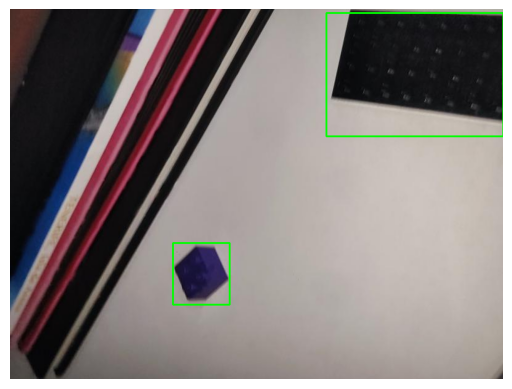

[INFO] EXIF metadata saved successfully.
[debug] Metadata saved to image: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw\image_564.jpg
{
    "image_name": "image_564.jpg",
    "inference_mode": "BricksOnly",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T19:55:20.587994",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 2
}
Prediction completed.


In [98]:
from random import randint
import os

# Load YOLO models
model_bricks = YOLO(r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\models\checkpoints\Brick_Model_best20250123_192838t.pt")  # Replace with your model path
model_studs = YOLO(r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\models\checkpoints\Stud_Model_best20250124_170824.pt" )    # Replace with your model path
# Define paths
#random interger from 0 to 1900
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw" 
images_folder_files = os.listdir(images_folder)
image_path_bricks = os.path.join(images_folder, images_folder_files[randint(0, len(images_folder_files)-1)])  # Random selection
working_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test"  # Folder for results


# Test 1: Run BricksOnly mode
predict_brick_dimensions(image_path_bricks, model_bricks, model_studs, mode="BricksOnly",
                         working_folder=working_folder, SAVE_ANNOTATED=True, PLT_ANNOTATED=True, SAVE_JSON=True)



0: 640x640 2 studs, 217.9ms
Speed: 7.0ms preprocess, 217.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


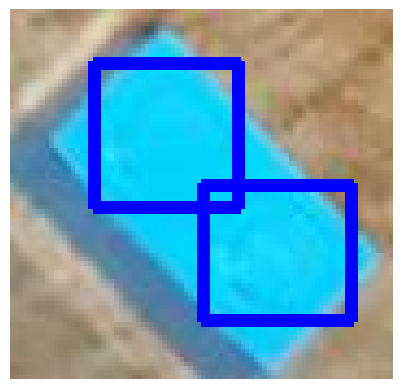

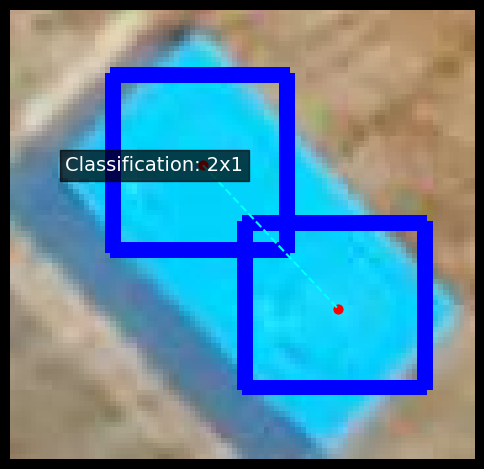

[INFO] EXIF metadata saved successfully.
[debug] Metadata saved to image: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_443_LegoBrick_2_c80.jpg
{
    "image_name": "image_443_LegoBrick_2_c80.jpg",
    "inference_mode": "StudsOnly",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T19:55:25.995448",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_studs_detected": 2,
    "classification_result": "2x1"
}
Prediction completed.


In [99]:


Crop_bricks_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks"
crop_bricks_files = os.listdir(Crop_bricks_folder)
image_path_studs =  os.path.join(Crop_bricks_folder, crop_bricks_files[randint(0, len(crop_bricks_files)-1)])  # Random selection


# Test 2: Run StudsOnly mode
predict_brick_dimensions(image_path_studs, model_bricks, model_studs, mode="StudsOnly",
                         working_folder=working_folder, SAVE_ANNOTATED=True, PLT_ANNOTATED=True, SAVE_JSON=True)



In [100]:
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw" 
images_folder_files = os.listdir(images_folder)
image_path_bricks = os.path.join(images_folder, images_folder_files[randint(0, len(images_folder_files)-1)])  # Random selection





0: 480x640 7 bricks, 416.3ms
Speed: 7.2ms preprocess, 416.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


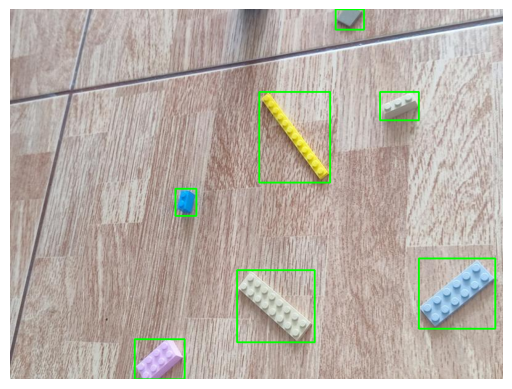


0: 480x640 7 studs, 235.5ms
Speed: 3.8ms preprocess, 235.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


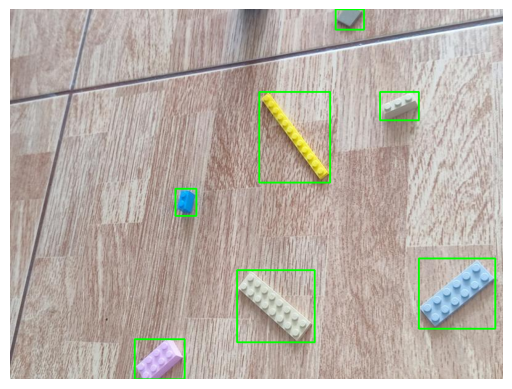

[INFO] No studs detected. Returning 'Unknown'.

0: 608x640 12 studs, 288.7ms
Speed: 8.6ms preprocess, 288.7ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


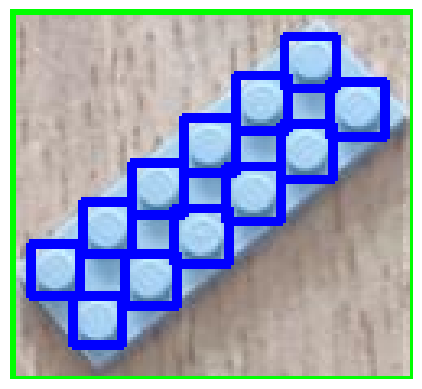

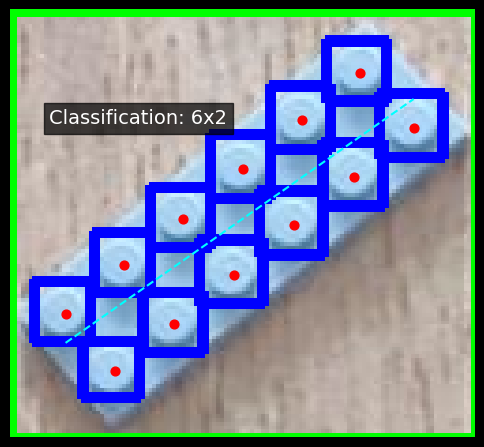


0: 544x640 8 studs, 203.3ms
Speed: 6.0ms preprocess, 203.3ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)


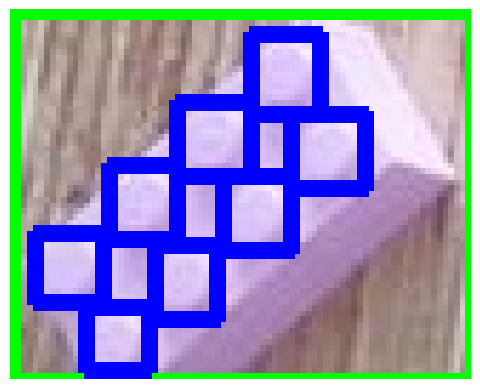

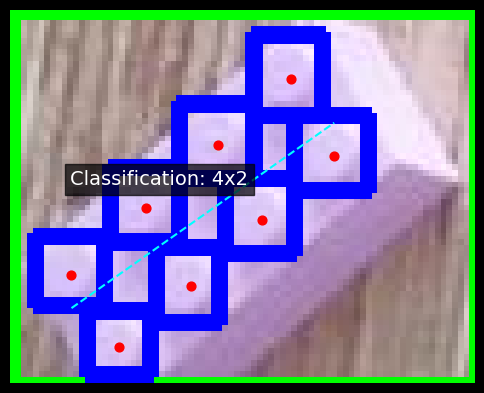


0: 640x512 12 studs, 233.8ms
Speed: 3.0ms preprocess, 233.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


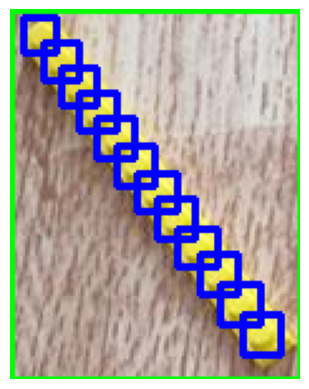

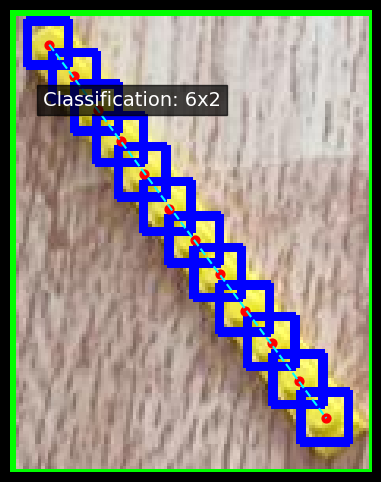


0: 608x640 16 studs, 145.5ms
Speed: 5.2ms preprocess, 145.5ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


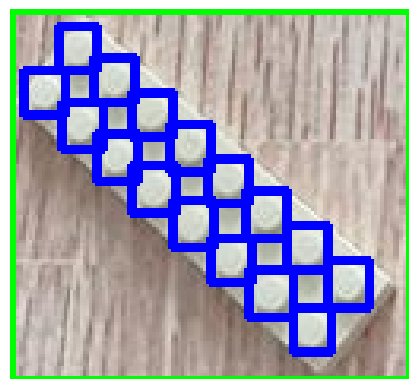

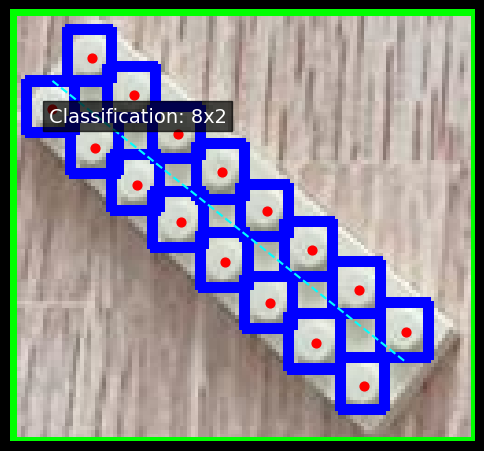


0: 480x640 3 studs, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


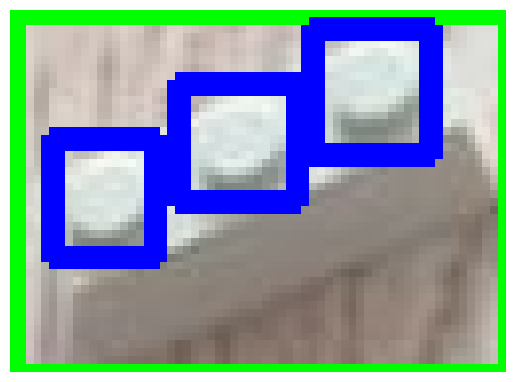

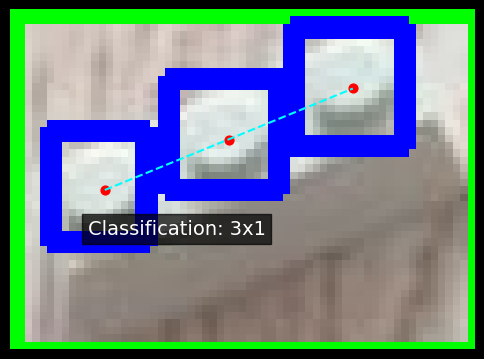


0: 480x640 (no detections), 188.2ms
Speed: 2.0ms preprocess, 188.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


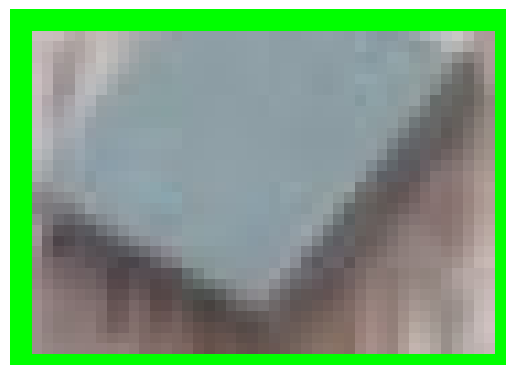

[INFO] No studs detected. Returning 'Unknown'.

0: 640x512 2 studs, 183.8ms
Speed: 5.0ms preprocess, 183.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


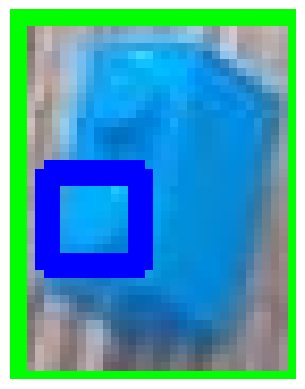

C:\Users\User\AppData\Local\Temp\ipykernel_25808\2315734786.py:257: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(xs, ys, 1)  # Linear regression (y = mx + b)


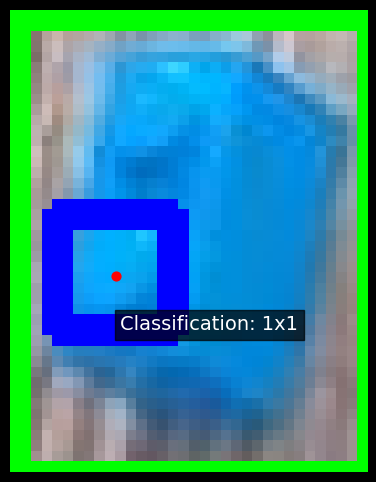

[INFO] EXIF metadata saved successfully.
[debug] Metadata saved to image: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw\image_646.jpg
{
    "image_name": "image_646.jpg",
    "inference_mode": "BricksAndStuds",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T19:58:42.552252",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 7,
    "total_studs_detected": 0,
    "classification_result": "Unknown",
    "bricks_analysis": [
        {
            "b

In [104]:

# Test 3: Run BricksAndStuds mode
predict_brick_dimensions(image_path_bricks, model_bricks, model_studs, mode="BricksAndStuds",
                         working_folder=working_folder, SAVE_ANNOTATED=True, PLT_ANNOTATED=True, SAVE_JSON=False)


In [105]:

# Test 4: Retrieve EXIF Metadata
metadata_exists, retrieved_metadata = retrieve_exif_metadata(image_path_bricks, CLEAN_IF_TRUE=False)
print("Metadata Exists:", metadata_exists)
if metadata_exists:
    print(retrieved_metadata)


{
    "image_name": "image_646.jpg",
    "inference_mode": "BricksAndStuds",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T19:58:42.552252",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 7,
    "total_studs_detected": 0,
    "classification_result": "Unknown",
    "bricks_analysis": [
        {
            "brick_bbox": [
                663.51513671875,
                404.1102600097656,
                787.1006469726562,
                518.730712890625
    

In [95]:

# Test 5: Clean EXIF Metadata
retrieve_exif_metadata(image_path_bricks, CLEAN_IF_TRUE=False)


{
    "image_name": "image_1086.jpg",
    "inference_mode": "BricksAndStuds",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T19:16:08.654900",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 4,
    "total_studs_detected": 3,
    "classification_result": "3x1",
    "bricks_analysis": [
        {
            "brick_bbox": [
                150.0556182861328,
                216.9519805908203,
                295.2765197753906,
                364.8259582519531
    

(True,
 {'image_name': 'image_1086.jpg',
  'inference_mode': 'BricksAndStuds',
  'model_bricks_hash': '1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee',
  'model_studs_hash': '2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d',
  'inference_datetime': '2025-01-28T19:16:08.654900',
  'script_execution_path': 'c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py',
  'working_directory': 'c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks',
  'python_version': '3.10.16',
  'os_info': 'Windows-10-10.0.22621-SP0',
  'hardware_info': 'Intel64 Family 6 Model 142 Stepping 11, GenuineIntel',
  'total_bricks_detected': 4,
  'total_studs_detected': 3,
  'classification_result': '3x1',
  'bricks_analysis': [{'brick_bbox': [150.0556182861328,
     216.9519805908203,
     295.2765197753906,
     364.8259582519531],
    'dimension': 'Unknown'},
   {'brick_bbox': [578.2745361328125,
     200.66470336914062,
     

In [4]:
# import os
# import multiprocessing

# num_threads = max(1, multiprocessing.cpu_count() // 2)  # Use half of available cores

# os.environ["OMP_NUM_THREADS"] = str(num_threads)
# os.environ["MKL_NUM_THREADS"] = str(num_threads)
# os.environ["OPENBLAS_NUM_THREADS"] = str(num_threads)
# os.environ["NUMEXPR_NUM_THREADS"] = str(num_threads)

# print(f"Optimized threading: Using {num_threads} threads")


Optimized threading: Using 4 threads


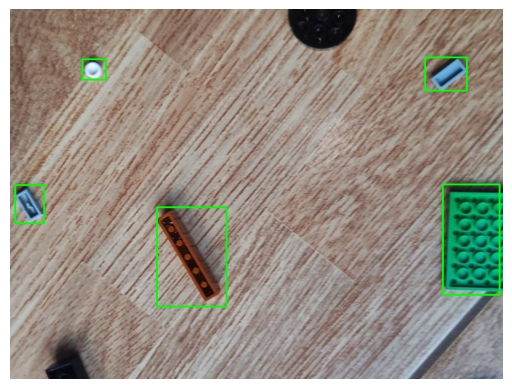

Processing completed.
Processing completed.


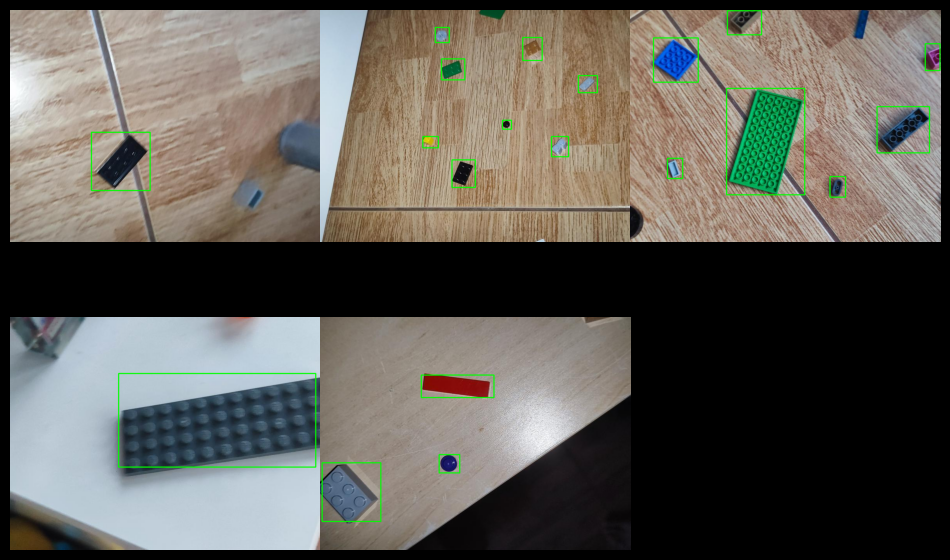

Processing completed.


In [30]:
import os
from random import randint

# Define paths
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw"  # Change this to the folder containing your images
labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\LabelMe_txt_bricks"  # Change this to the folder containing your YOLO .txt annotation files
output_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test"  # Used in Mode 2 and Mode 4

# # Test Mode 1: Display a single image with annotations
image_path = os.path.join(images_folder, f"image_{str(randint(0, 1900))}.jpg")  # Replace with an actual image name

visualize_yolo_annotations(image_path, labels_folder, mode=1)

# Test Mode 2: Save a single image with annotations
visualize_yolo_annotations(image_path, labels_folder, mode=2, extra_param=output_folder)

# Test Mode 3: Display a grid of random images with annotations (default: 6 images)
visualize_yolo_annotations(images_folder, labels_folder, mode=3, extra_param=5)

# Test Mode 4: Save all images in a folder with annotations
# visualize_yolo_annotations(images_folder, labels_folder, mode=4, extra_param=output_folder)


In [8]:

input_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\input test"
output_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test"
# labelme_to_yolo(input_folder, output_folder)

# convert_keypoints_json(input_folder, output_folder)
labelme_to_yolo(output_folder, output_folder)

Conversion completed. YOLO .txt files saved to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test
